In [73]:
import hist

from utilities.io_tools import input_tools
from utilities.styles import styles
from utilities import common

from wremnants import plot_tools
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

import numpy as np
from utilities import boostHistHelpers as hh
import mplhep as hep
from wremnants import histselections as sel

colors = mpl.colormaps["tab10"]

In [165]:
output_dir = "/eos/home-d/dwalter/www/WMassAnalysis/240119_closure_fakes/dPhiMuonMetCut/QCDPt5"

In [120]:
def load(name, ptMuon=5):
    if name=="":
        h = input_tools.load_and_scale(res, f"QCDmuEnrichPt15PostVFP", histname)
    else:    
        h = input_tools.load_and_scale(res2, f"QCDPt{name}muEnrichPt5PostVFP", histname)
    return h

In [158]:
histograms = "/scratch/dwalter/results_histmaker/240119_AllQCDMC/mw_with_mu_eta_pt_dPhiMuonMetCut.hdf5"
res, meta, _ = input_tools.read_infile(histograms)
hQCD = load("")

In [176]:
histograms = "/scratch/dwalter/results_histmaker/240119_test_fakes/mw_with_mu_eta_pt_scetlib_dyturboCorr_lowMT.hdf5"
res, meta, _ = input_tools.read_infile(histograms)
hData = input_tools.load_and_scale(res, "dataPostVFP", "nominal")
res.keys()
hData.sum()

WeightedSum(value=1.58119e+07, variance=1.58119e+07)

In [159]:
histograms2 = "/scratch/dwalter/results_histmaker/240119_AllQCDMC/mw_with_mu_eta_pt_dPhiMuonMetCut.hdf5"
histname = "nominal" #histname
res2, meta2, _ = input_tools.read_infile(histograms2)

hQCD15To20 = load("15To20")
hQCD20To30 = load("20To30")
hQCD30To50 = load("30To50")
hQCD50To80 = load("50To80")
hQCD80To120 = load("80To120")
hQCD120To170 = load("120To170")
hQCD170To300 = load("170To300")
hQCD300To470 = load("300To470")
hQCD470To600 = load("470To600")
hQCD600To800 = load("600To800")
hQCD800To1000 = load("800To1000")
hQCD1000 = load("1000")

In [162]:
hQCDFake = sel.fakeHistABCD(hQCD)#, fakerate_integration_axes=["eta"])
hQCDSig = sel.signalHistWmass(hQCD)

In [145]:
hQCDFake_pt = hQCDFake.project("pt")
hQCDSig_pt = hQCDSig.project("pt")

In [146]:
from scipy.optimize import curve_fit

def exp_fall(x, a, b, c):
    return a * np.exp(-b * x) + c

In [147]:
def plot(hss, labels, linestyles=None, h1ds_nom=None, ratio=True, flow=False, showFlow=False, vars=["pt"], name="", 
         fit=True, variances=False, uncertainty_bands=True):

    if linestyles is None:
        linestyles = ["-"]*len(labels)
    
    if h1ds_nom is not None:
        hs = [*hss, *h1ds_nom]
        hr = [*[hh.divideHists(h1d, hss[0]) for h1d in hss], *[hh.divideHists(h1d, h1ds_nom[0]) for h1d in h1ds_nom]]
    else:
        hs = hss
        hr = [hh.divideHists(h1d, hss[0]) for h1d in hss]

    if variances:
        ratio=False
        for h in hs:
            h.values(flow=True)[...] = np.sqrt(h.variances(flow=True))/h.values(flow=True)
            h.variances(flow=True)[...] = np.zeros(h.values(flow=True).shape).astype(int)
        for h in hr:
            h.values(flow=True)[...] = np.sqrt(h.variances(flow=True))/h.values(flow=True)
            h.variances(flow=True)[...] = np.zeros(h.values(flow=True).shape).astype(int)

    ylabel="a.u."
    if variances:
        ylabel="Rel. uncertainty"
    
    ymin = 0
    ymax = None

    ymax = ymax if ymax is not None else max([max(h.values(flow=showFlow)) for h in hs])
    ymin = ymin if ymin is not None else min([min(h.values(flow=showFlow)) for h in hs])
    yrange = ymax - ymin
    ymin = ymin if ymin == 0 else ymin - yrange*0.3
    ymax = ymax + yrange*0.3

    if ratio:
        fig, ax1, ax2 = plot_tools.figureWithRatio(hss[0], xlabel=f"{'-'.join(vars)} Bin", ylabel=ylabel,
                                         rlabel="1./nominal", rrange=(0.25, 1.75), cms_label="Preliminary",
                                         automatic_scale=False, width_scale=1.2, ylim=(ymin, ymax))
    else:
        fig, ax1 = plot_tools.figure(hss[0], xlabel=f"{'-'.join(vars)} Bin", ylabel=ylabel,
                                         cms_label="Preliminary",
                                         automatic_scale=False, width_scale=1.2, ylim=(ymin, ymax))
          
    hep.histplot(
        hs,
        histtype = "step",
        color = [colors(i) for i in range(len(hss))],
        label = labels[:len(hs)],
        linestyle = linestyles[:len(hs)],
        ax = ax1
    )

    if ratio:
        hep.histplot(
            hr,
            yerr=False,
            histtype = "step",
            color = [colors(i) for i in range(len(hss))],
            label = labels[:len(hs)],
            linestyle = linestyles[:len(hs)],
            ax = ax2
        )

    if fit:
        y_fit0 = None
        for i, h in enumerate(hs):
            xedges = h.axes["pt"].edges
            x = h.axes["pt"].centers
            y = h.values(flow=showFlow)
            y_err = h.variances(flow=showFlow)

            y_fit = sel.fit_multijet_bkg(h)
            y_err = np.array([y.s for y in y_fit])
            y_fit = np.array([y.n for y in y_fit])

            ax1.plot(x, y_fit, linestyle="--", color=colors(i))
            if uncertainty_bands:
                ax1.bar(x=xedges[:-1], height=2*y_err, bottom=y_fit - y_err, width=np.diff(xedges), align='edge', linewidth=0, alpha=0.3, color=colors(i), zorder=-1)

            # if i==0:
            #     y_fit0 = y_fit
            # elif ratio:
            #     ax2.plot(x, y_fit/y_fit0, linestyle="--, color=colors(i))

            if ratio:
                ax2.plot(x, y/y_fit, linewidth=0, linestyle=None, marker="o", color=colors(i))
            
    
    #     ax.fill_between(x, y - err, y + err, alpha=0.3, color=colors(i), step="post")

    # ax.text(1.0, 1.003, text_dict[base_process], transform=ax.transAxes, fontsize=30,
    #         verticalalignment='bottom', horizontalalignment="right")
    plot_tools.addLegend(ax1, ncols=2, text_size=12)
    # if ratio:
    #     plot_name = plotname+"_ratio"
    # else:
    #     plot_name = plotname
    plot_tools.save_pdf_and_png(output_dir, f"closure_fakes_{name}")

    return hr

Sum(all) = WeightedSum(value=2976.59, variance=136.947)
Sum(hQCD15To20) = WeightedSum(value=31.6748, variance=20.7035)
Sum(hQCD20To30) = WeightedSum(value=264.284, variance=25.7371)
Sum(hQCD30To50) = WeightedSum(value=769.317, variance=34.8665)
Sum(hQCD50To80) = WeightedSum(value=335.004, variance=7.03899)
Sum(hQCD80To120) = WeightedSum(value=47.9934, variance=0.227732)
Sum(hQCD120To17) = WeightedSum(value=7.21528, variance=0.00897096)
Sum(hQCD170To300) = WeightedSum(value=1.60941, variance=0.000378205)
Sum(hQCD300To470) = WeightedSum(value=0.0994632, variance=2.35472e-06)
Sum(hQCD470To600) = WeightedSum(value=0.00836842, variance=2.90685e-08)
Sum(hQCD600To800) = WeightedSum(value=0.00227932, variance=2.61656e-09)
Sum(hQCD800To1000) = WeightedSum(value=0.000399577, variance=3.83695e-11)
Sum(hQCD1000) = WeightedSum(value=0.000123602, variance=1.09599e-11)
Sum(Sum) = WeightedSum(value=1457.21, variance=88.5833)
Sum(Inclusive) = WeightedSum(value=1488.29, variance=34.2367)


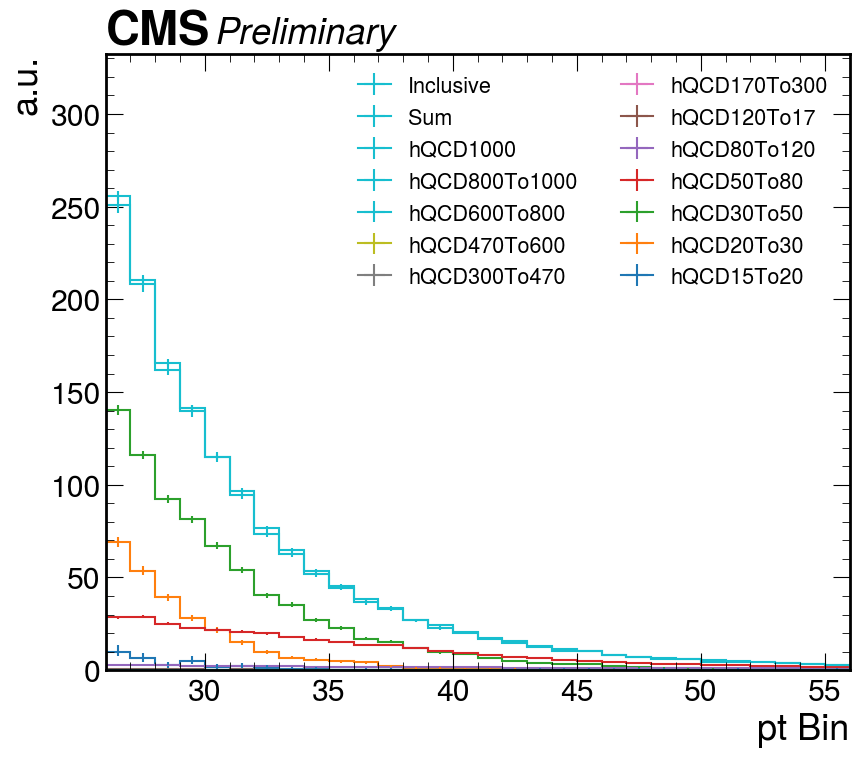

In [161]:
hists = [hQCD15To20, hQCD20To30, hQCD30To50, hQCD50To80, hQCD80To120, hQCD120To170, 
         hQCD170To300, hQCD300To470, hQCD470To600, hQCD600To800, hQCD800To1000, hQCD1000]
labels = ["hQCD15To20", "hQCD20To30", "hQCD30To50", "hQCD50To80", "hQCD80To120", "hQCD120To17", 
         "hQCD170To300", "hQCD300To470", "hQCD470To600", "hQCD600To800", "hQCD800To1000", "hQCD1000"]

hists_sum = hh.sumHists(hists)#.project("pt")


hist_sumall = hh.sumHists([*hists, hQCD])#.project("pt")
hQCD = hh.scaleHist(hist_sumall, 0.5)
print(f"Sum(all) = {hist_sumall.sum()}")

labels.append("Sum")

labels.append("Inclusive")
hists_pt = [h.project("pt") for h in [*hists, hists_sum, hQCD]]

for l, h in zip(labels, hists_pt):
    print(f"Sum({l}) = {h.sum()}")

hratio = plot(hists_pt, labels, name="QCDPt5", fit=False, ratio=False)

/opt/venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

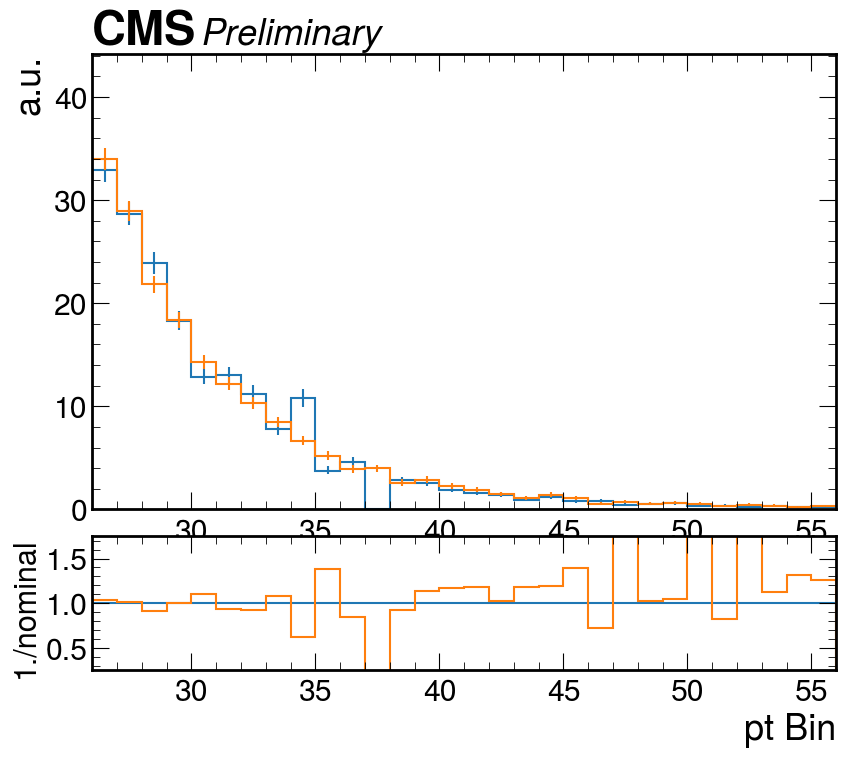

In [149]:
hQCDFake_ptq = hQCDFake.project("pt", "charge")
hQCDSig_ptq = hQCDSig.project("pt", "charge")

hratio = plot([hQCDFake_ptq[{"charge":0}], hQCDSig_ptq[{"charge":0}]], labels=["C*B/A", "D"], name="QCD_minus")
hratio = plot([hQCDFake_ptq[{"charge":1}], hQCDSig_ptq[{"charge":1}]], labels=["C*B/A", "D"], name="QCD_plus")

hratio = plot([hQCDFake_pt, hQCDSig_pt], labels=["C*B/A", "D"], name="QCD")
hratio[1].values()

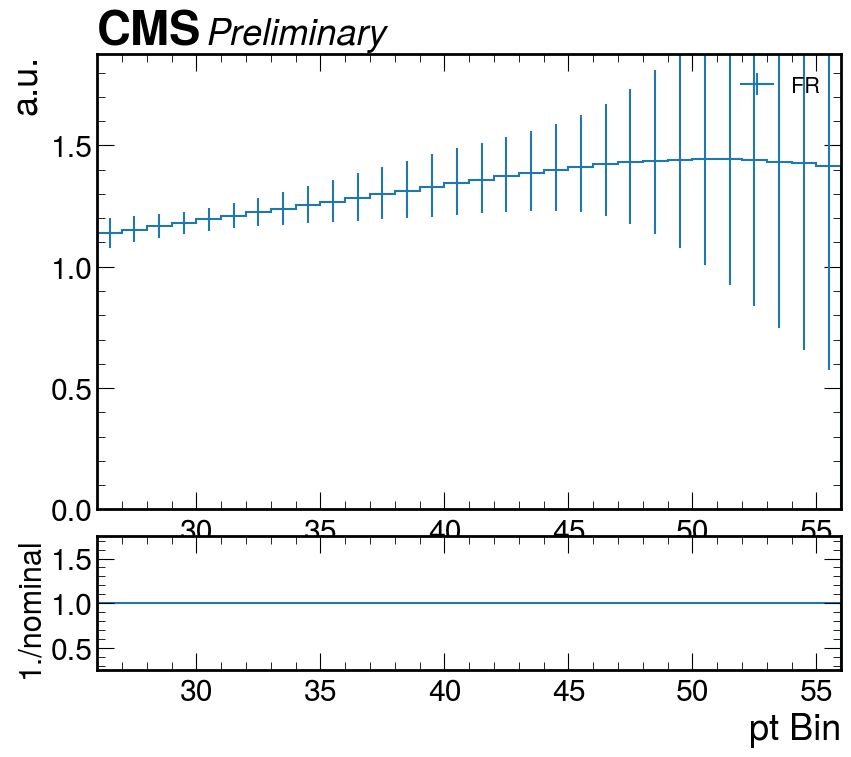

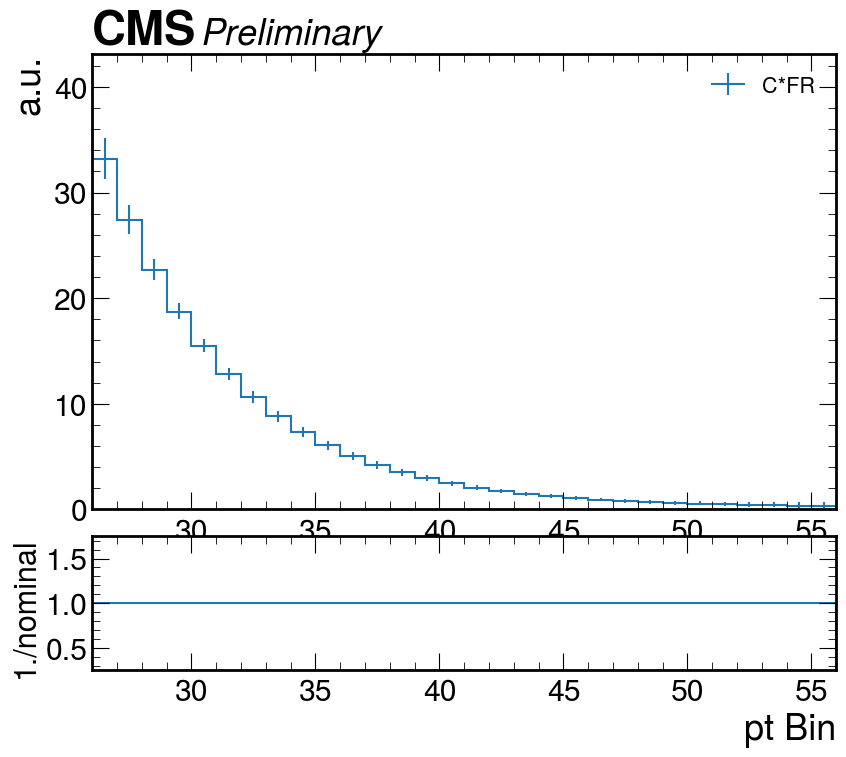

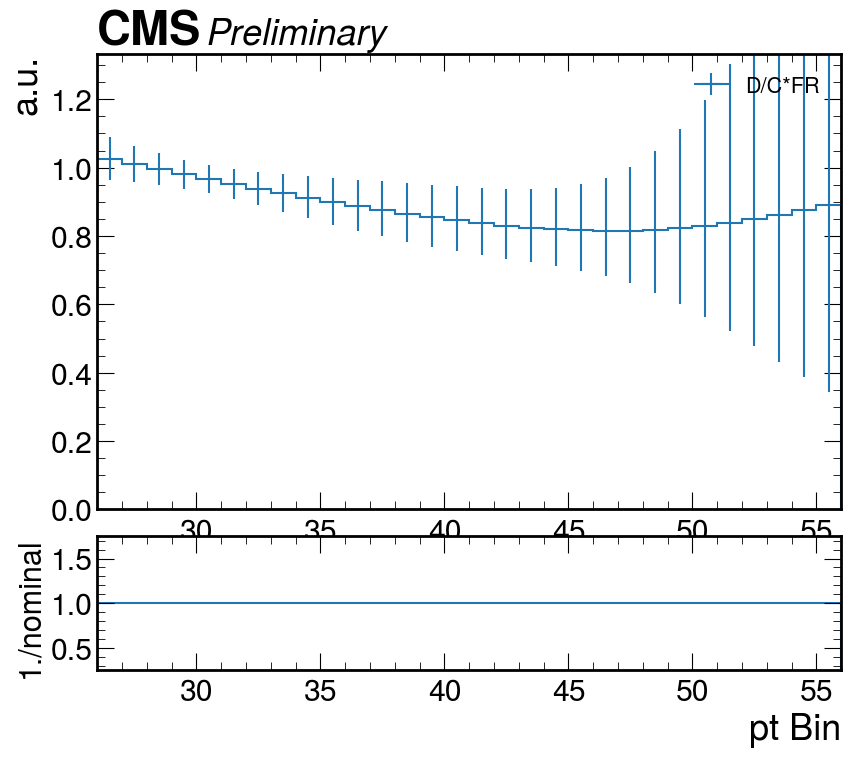

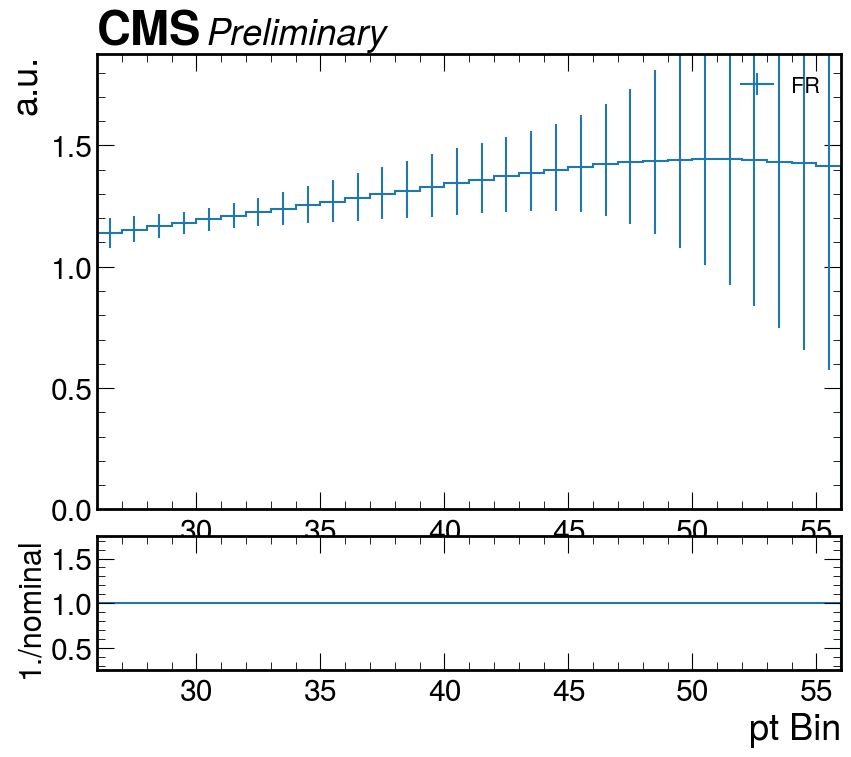

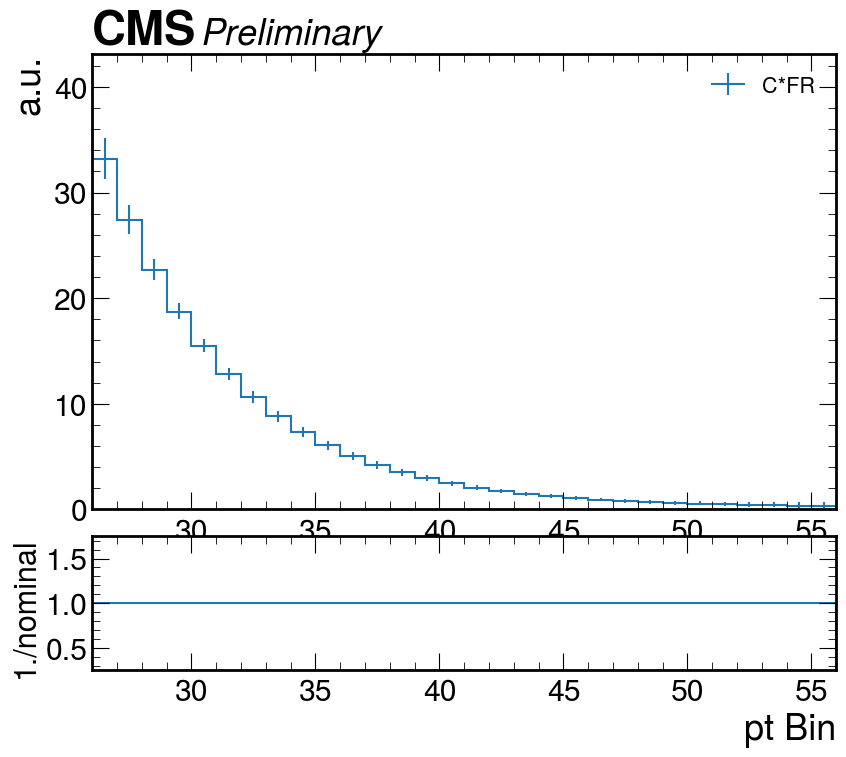

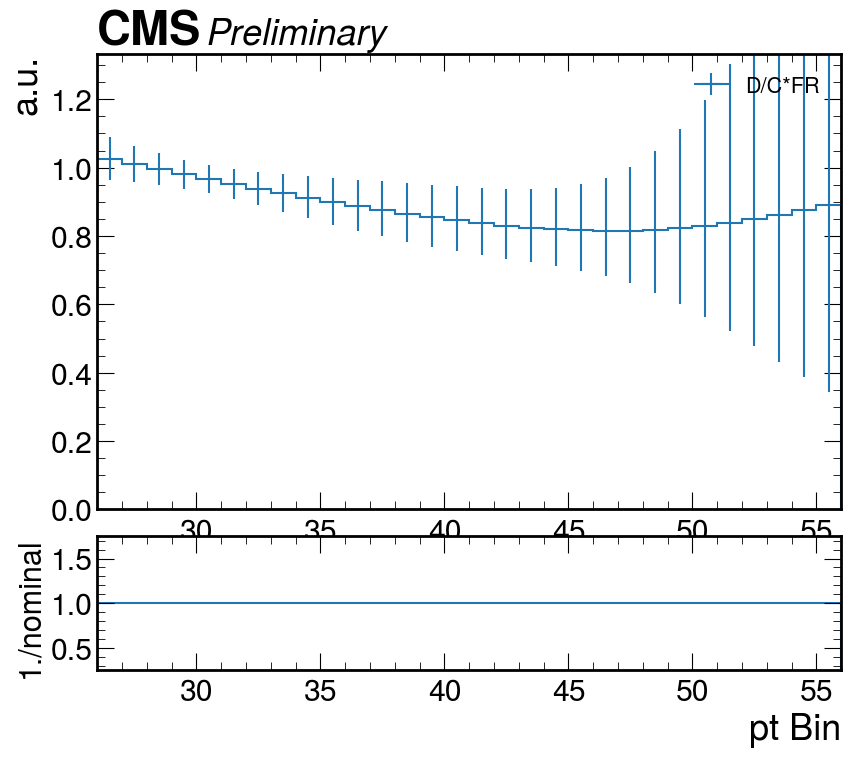

In [150]:
# plot fakes in each region separately
for idx_x in (0,1):
    idx_eta=0
    hQCD_D = hQCD[{"charge":idx_c,"passIso":1,"passMT":1}]
    hQCD_B = hQCD[{"charge":idx_c,"passIso":1,"passMT":0}]
    hQCD_C = hQCD[{"charge":idx_c,"passIso":0,"passMT":1}]
    hQCD_A = hQCD[{"charge":idx_c,"passIso":0,"passMT":0}]

    hQCD_A_pt = hQCD_A.project("pt")
    hQCD_B_pt = hQCD_B.project("pt")
    hQCD_C_pt = hQCD_C.project("pt")
    hQCD_D_pt = hQCD_D.project("pt")
    
    # hQCDFake_BA_pt = hh.divideHists(hQCD_B,hQCD_A).project("pt")
    # hQCDFake_CBA_pt = hh.multiplyHists(hQCD_C,hh.divideHists(hQCD_B,hQCD_A)).project("pt")
    
    # plot([hQCD_A_pt, hQCD_B_pt, hQCD_C_pt, hQCD_D_pt], labels=["A", "B", "C", "D"], name=f"QCD_q{idx_c}", ratio=True)
    
    # plot([hQCD_A_pt], labels=["A"], name=f"QCD_A_q{idx_c}", ratio=True)
    # plot([hQCD_B_pt], labels=["B"], name=f"QCD_B_q{idx_c}", ratio=True)
    # plot([hQCD_C_pt], labels=["C"], name=f"QCD_C_q{idx_c}", ratio=True)
    # plot([hQCD_D_pt], labels=["D"], name=f"QCD_D_q{idx_c}", ratio=True)

    def set(h):
        vals = sel.fit_multijet_bkg(h)
        h.view()[...] = np.array([(v.n,v.s**2) for v in vals])

    set(hQCD_A_pt)
    set(hQCD_B_pt)
    set(hQCD_C_pt)
    set(hQCD_D_pt)

    # plot([hQCD_A_pt], labels=["A"], name=f"QCD_A_q{idx_c}_smooth", ratio=True, fit=False)
    # plot([hQCD_B_pt], labels=["B"], name=f"QCD_B_q{idx_c}_smooth", ratio=True, fit=False)
    # plot([hQCD_C_pt], labels=["C"], name=f"QCD_C_q{idx_c}_smooth", ratio=True, fit=False)
    # plot([hQCD_D_pt], labels=["D"], name=f"QCD_D_q{idx_c}_smooth", ratio=True, fit=False)

    hQCD_FR = hh.divideHists(hQCD_B_pt, hQCD_A_pt)
    hQCD_CBA = hh.multiplyHists(hQCD_C_pt, hQCD_FR)
    hQCD_DCBA = hh.divideHists(hQCD_D_pt, hQCD_CBA)
    plot([hQCD_FR], labels=["FR"], name=f"FR_q{idx_c}_smooth", ratio=True, fit=False)
    plot([hQCD_CBA], labels=["C*FR"], name=f"CFR_q{idx_c}_smooth", ratio=True, fit=False)
    plot([hQCD_DCBA], labels=["D/C*FR"], name=f"DCFR_q{idx_c}_smooth", ratio=True, fit=False)



In [151]:
# plot fakes in each region separately
idx_c=0
hQCD_D = hQCD[{"charge":idx_c,"passIso":1,"passMT":1}]
hQCD_B = hQCD[{"charge":idx_c,"passIso":1,"passMT":0}]
hQCD_C = hQCD[{"charge":idx_c,"passIso":0,"passMT":1}]
hQCD_A = hQCD[{"charge":idx_c,"passIso":0,"passMT":0}]

hQCD_A_pt = hQCD_A.project("pt")
hQCD_B_pt = hQCD_B.project("pt")
hQCD_C_pt = hQCD_C.project("pt")
hQCD_D_pt = hQCD_D.project("pt")

[Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=30, variance=1.82553),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=5.97038, variance=0.171462),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=7.62044, variance=0.302498),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=26.1014, variance=1.55505)]

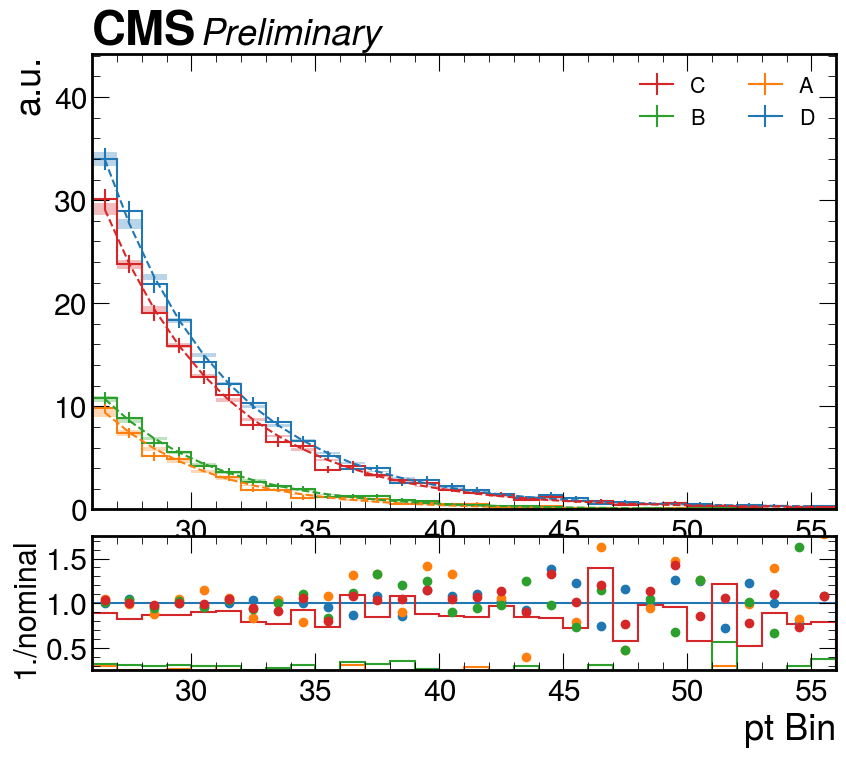

In [152]:
hQCDFake_BA_pt = hh.divideHists(hQCD_B,hQCD_A).project("pt")
hQCDFake_CBA_pt = hh.multiplyHists(hQCD_C,hh.divideHists(hQCD_B,hQCD_A)).project("pt")

plot([hQCD_D_pt, hQCD_A_pt, hQCD_B_pt, hQCD_C_pt], labels=["D", "A", "B", "C"], name="QCD", ratio=True)

[Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=30, variance=1.82553),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=36.4602, variance=31.0032),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=36.4602, variance=31.0032)]

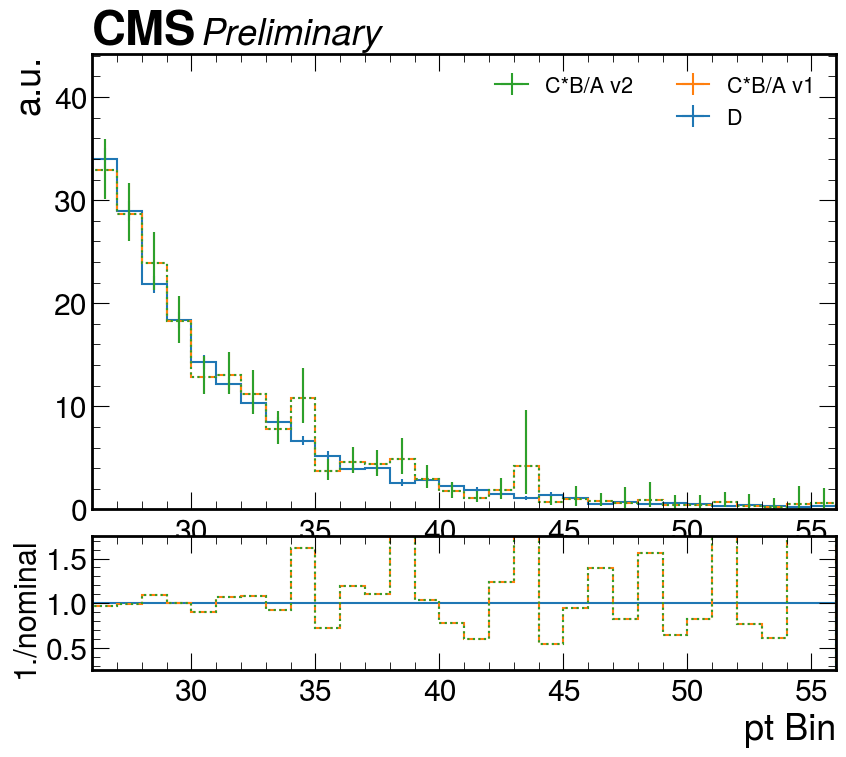

In [153]:
# compute fakes via ABCD directly here, not using wremnants functions, check numerical stability
hQCDFake_v1_pt = hh.multiplyHists(hQCD_C_pt,hh.divideHists(hQCD_B_pt,hQCD_A_pt))
hQCDFake_v2_pt = hh.divideHists(hh.multiplyHists(hQCD_C_pt,hQCD_B_pt),hQCD_A_pt)

plot([hQCD_D_pt, hQCDFake_v1_pt, hQCDFake_v2_pt], labels=["D", "C*B/A v1", "C*B/A v2"], name="QCD", fit=False, linestyles=["-","--", ":"])

In [154]:
import hist
def unrolledHist(h, obs=['pt', 'eta']):
    bins = np.multiply(*[len(a) for a in h.axes if a.name in obs])
    newh = hist.Hist(hist.axis.Regular(bins, 0, bins), storage=h.storage_type())
    newh[...] = np.ravel(h.project(*obs))
    return newh

[Hist(Regular(9, 0, 9, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=9, variance=0.113295) (WeightedSum(value=11, variance=0.113295) with flow),
 Hist(Regular(9, 0, 9, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=9.66176, variance=0.360617) (WeightedSum(value=11.6618, variance=0.360617) with flow)]

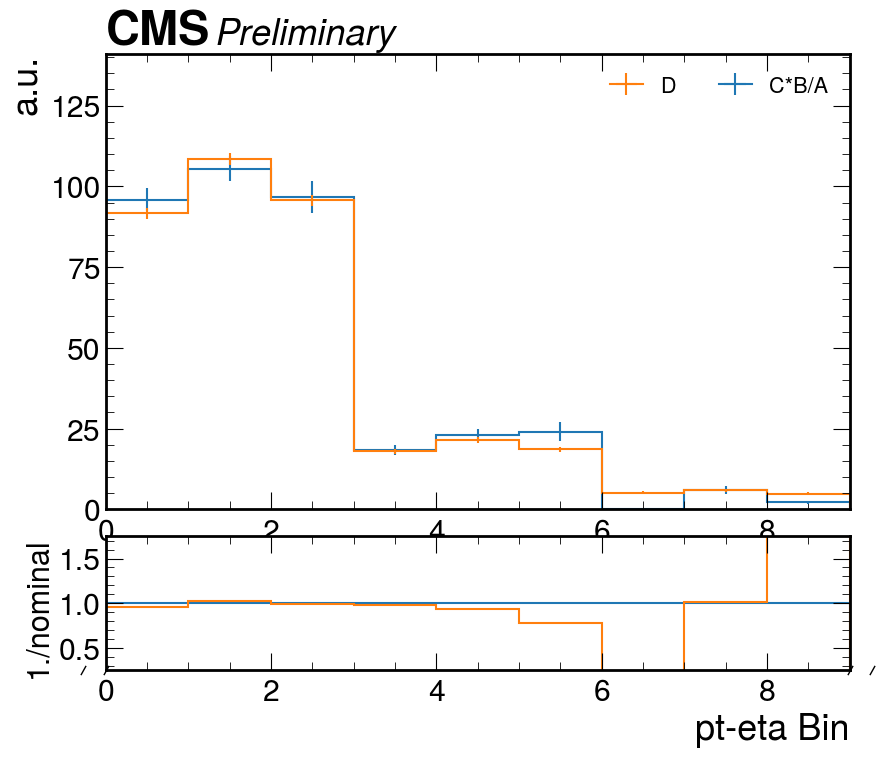

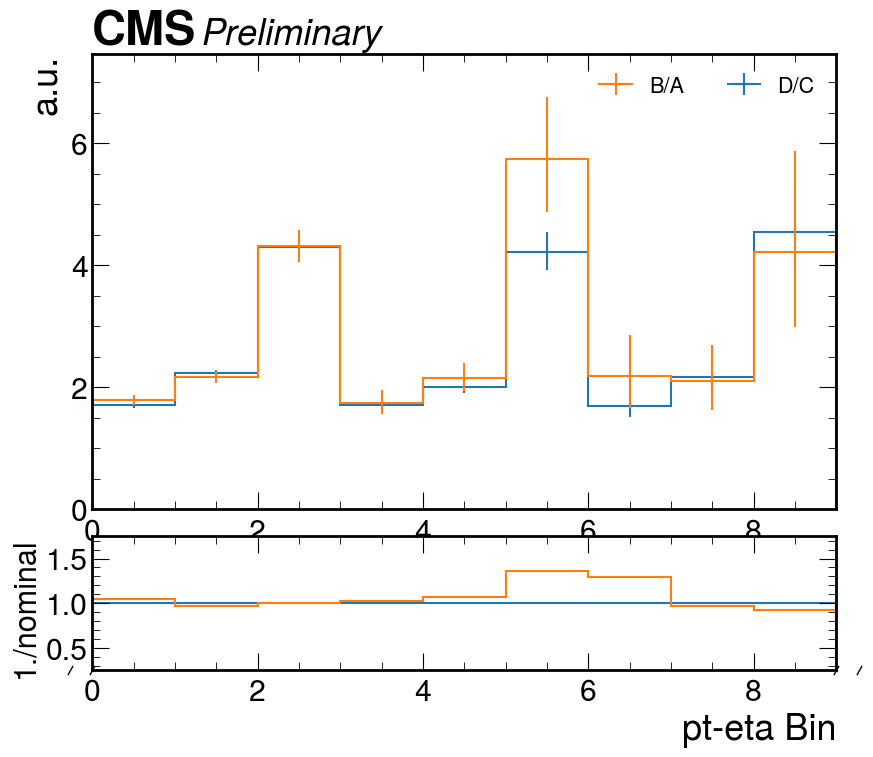

In [157]:
vars = ["pt","eta"]
h1ds = [unrolledHist(h, obs=vars) if len(vars) > 1 else h.project(*vars) for h in [hQCDFake, hQCDSig]]
plot(h1ds, ["C*B/A", "D"], name="QCD_pt_eta", fit=False, vars=vars)

hQCD_DC = hh.divideHists(hQCD_D, hQCD_C)
hQCD_BA = hh.divideHists(hQCD_B, hQCD_A)

h1ds = [unrolledHist(h, obs=vars) if len(vars) > 1 else h.project(*vars) for h in [hQCD_DC, hQCD_BA]]

plot(h1ds, ["D/C", "B/A"], name="QCD_pt_eta_ratios", fit=False, vars=vars)


In [164]:
def project(flow=False):
    # average over bins
    if flow:
        return lambda h, axes: h.project(*axes)/np.prod([a.extent for a in h.axes if a.name not in axes])
    else:
        return lambda h, axes: hh.projectNoFlow(h, axes)/np.prod([a.size for a in h.axes if a.name not in axes])

def make_plot_2d(h, name, proc, axes, corr=None, plot_error=False, clim=None, flow=False, density=False, log=False):
    
    h2d = project(flow)(h, axes)

    xlabel = styles.axis_labels.get(axes[0],axes[0])
    ylabel = styles.axis_labels.get(axes[1],axes[1])

    if flow:
        xedges, yedges = plot_tools.extendEdgesByFlow(h2d)
    else:
        edges = h2d.axes.edges
        xedges = np.reshape(edges[0], len(edges[0]))
        yedges = edges[1][0]

    if density:
        xbinwidths = np.diff(xedges)
        ybinwidths = np.diff(yedges)
        binwidths = np.outer(xbinwidths, ybinwidths) 
        h2d.values(flow=flow)[...] = h2d.values(flow=flow) / binwidths

    if plot_error:
        # plot relative errors instead
        h2d.values(flow=flow)[...] = np.sqrt(hh.relVariance(h2d.values(flow=flow), h2d.variances(flow=flow), fillOnes=True))

    # if args.xlim[0] is None:
    xlim = (xedges[0],xedges[-1])
    # else:
    #     xlim = args.xlim

    # if args.ylim[0] is None:
    ylim = (yedges[0],yedges[-1])
    # else:
    #     ylim = args.ylim

    fig, ax = plot_tools.figure(h2d, xlabel=xlabel, ylabel=ylabel, cms_label="Work in progress", automatic_scale=False, width_scale=1.2, xlim=xlim, ylim=ylim)

    if clim is None:
        if log:
            cmin = min(h2d.values(flow=flow)[h2d.values(flow=flow)>0]) # smallest value that is not 0
            cmax = h2d.values(flow=flow).max()
        else:
            cmin = max(0.95,h2d.values(flow=flow).min())
            cmax = min(1.05,h2d.values(flow=flow).max())
        # make symmetric range
        crange = max((cmax-1), (1-cmin))
        clim = [max(0.95,1-crange), min(1.05,1+crange)]
    else:
        # colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, norm=LogNorm(vmin=clim[0], vmax=clim[1]), cmap=cm.RdBu)

        if log:
            colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, cmap=cm.RdBu, norm=LogNorm(vmin=clim[0], vmax=clim[1]))
        else:
            colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, cmap=cm.RdBu, vmin=clim[0], vmax=clim[1])

    cbar = fig.colorbar(colormesh, ax=ax)

    ax.text(1.0, 1.003, styles.text_dict.get(proc, proc), transform=ax.transAxes, fontsize=30,
            verticalalignment='bottom', horizontalalignment="right")

    # outfile = f"hist2d_{'_'.join(axes)}_{proc}_{name}"
    # if corr:
    #     outfile += f'_{corr.replace("(","").replace(")","")}'
    # if args.postfix:
    #     outfile += f"_{args.postfix}"
    # plot_tools.save_pdf_and_png(outdir, outfile)
    # plot_tools.write_index_and_log(outdir, outfile, args=args)
    plot_tools.save_pdf_and_png(output_dir, f"closure_fakes_2D_{name}")

0


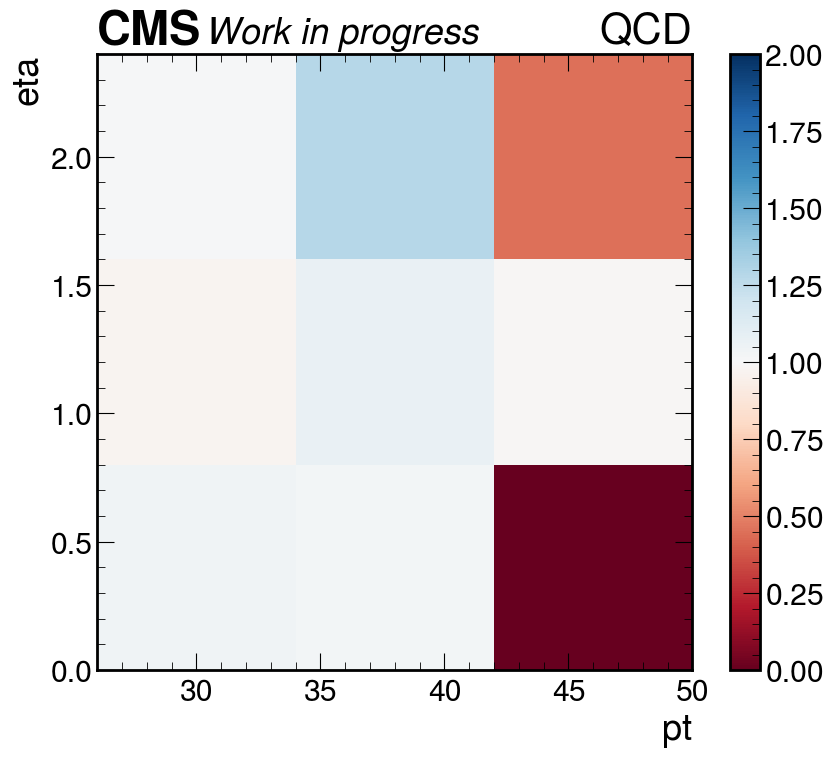

In [156]:
# compute nonclosure in 3D (eta-pt-charge)
hQCD1 = hh.makeAbsHist(hQCD, "eta", rename=False)
hQCD1 = hQCD1[{"pt":hist.rebin(4), "eta":hist.rebin(8)}]

hQCD_D = hQCD1[{"passIso":1,"passMT":1}]
hQCD_B = hQCD1[{"passIso":1,"passMT":0}]
hQCD_C = hQCD1[{"passIso":0,"passMT":1}]
hQCD_A = hQCD1[{"passIso":0,"passMT":0}]

print((hQCD1.values()==0).sum())

hQCDFake = sel.fakeHistABCD(hQCD1, fakerate_integration_axes=["charge"])
hQCDSig = sel.signalHistWmass(hQCD1)

hQCDClosure = hh.divideHists(hQCDFake, hQCDSig)
make_plot_2d(hQCDClosure, "QCD", "QCD", ["pt","eta"],clim=(0,2))

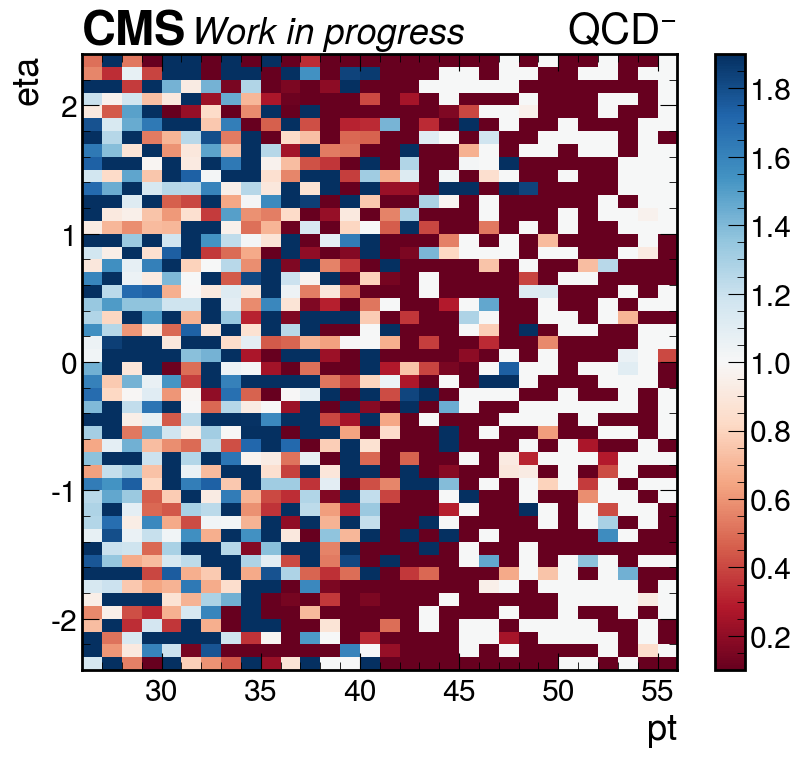

In [20]:
hQCDClosure = hh.divideHists(hQCDFake[{"charge":0}], hQCDSig[{"charge":0}])
make_plot_2d(hQCDClosure, "QCD_minus", "$QCD^{-}$", ["pt","eta"],clim=(0.1,1.9))

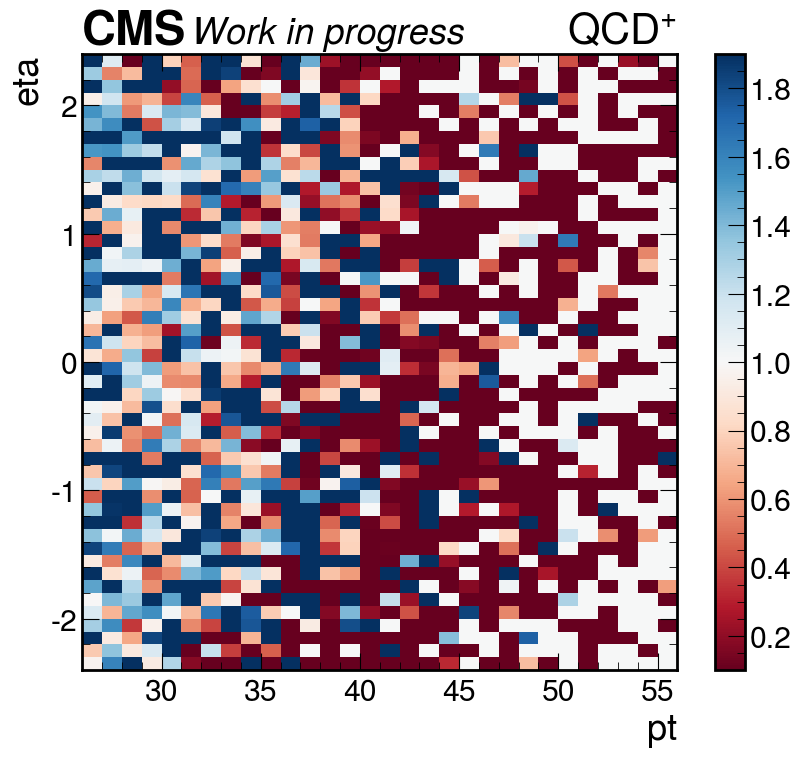

In [21]:
hQCDClosure = hh.divideHists(hQCDFake[{"charge":1}], hQCDSig[{"charge":1}])
make_plot_2d(hQCDClosure, "QCD_plus", "$QCD^{+}$", ["pt","eta"],clim=(0.1,1.9))

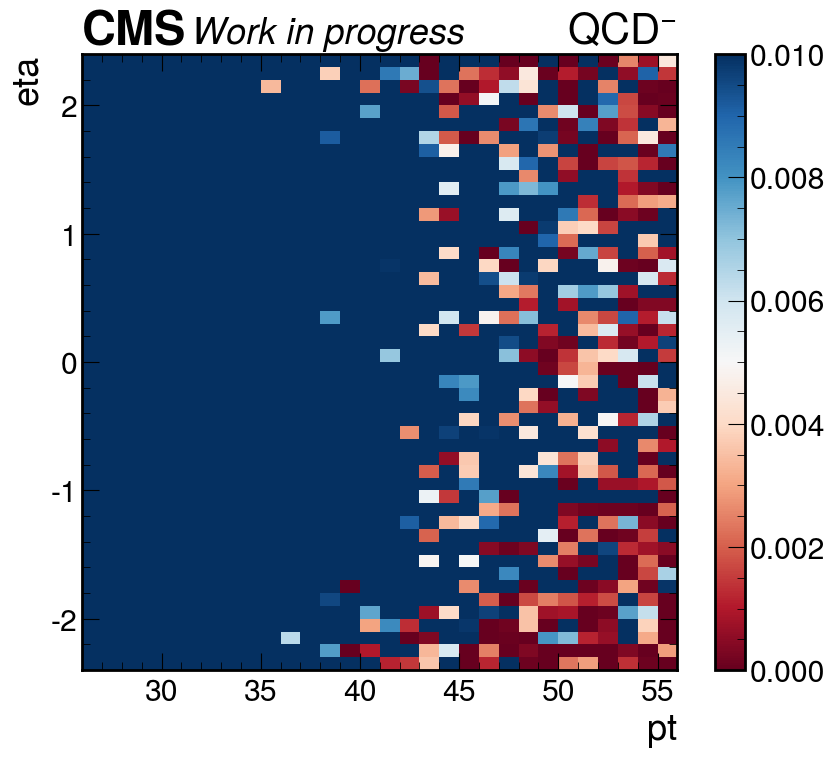

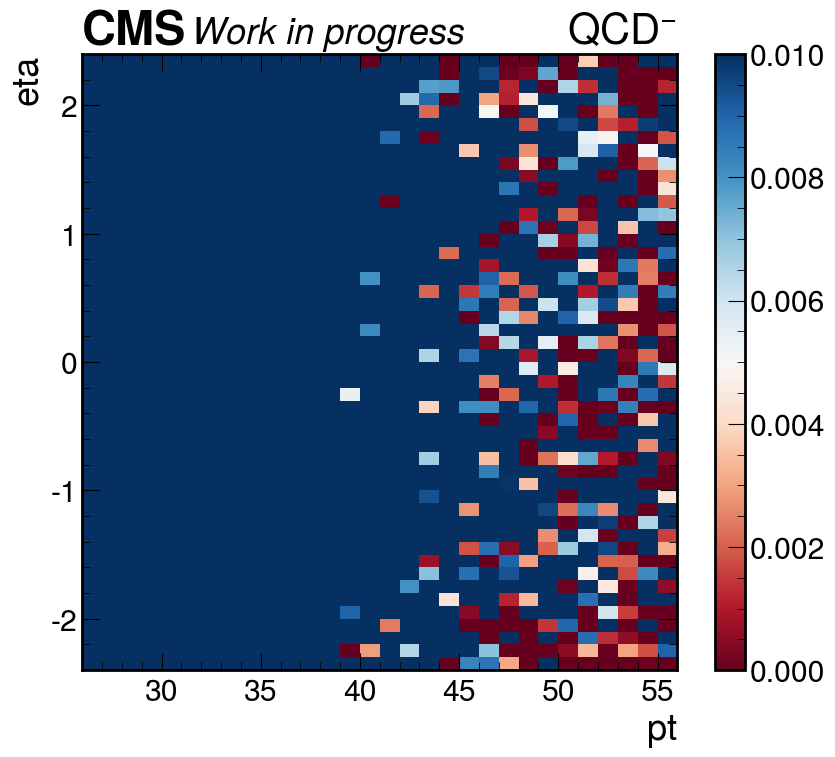

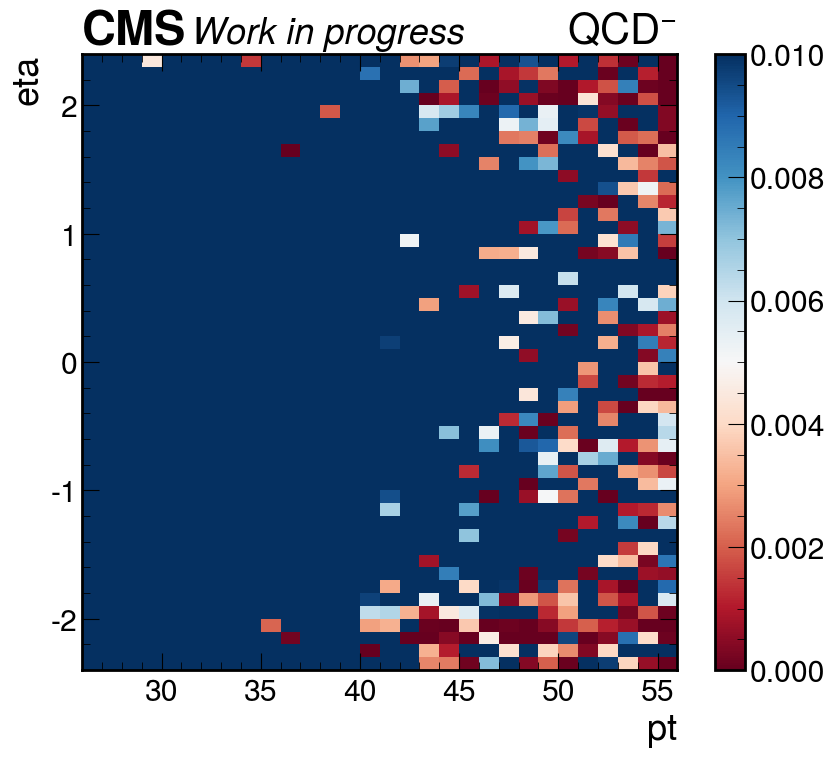

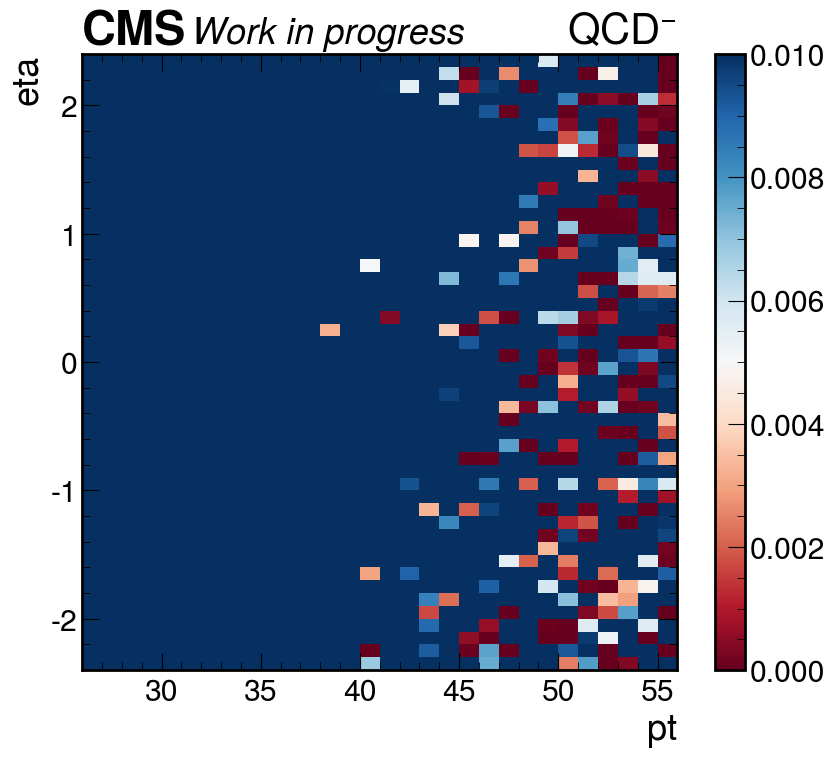

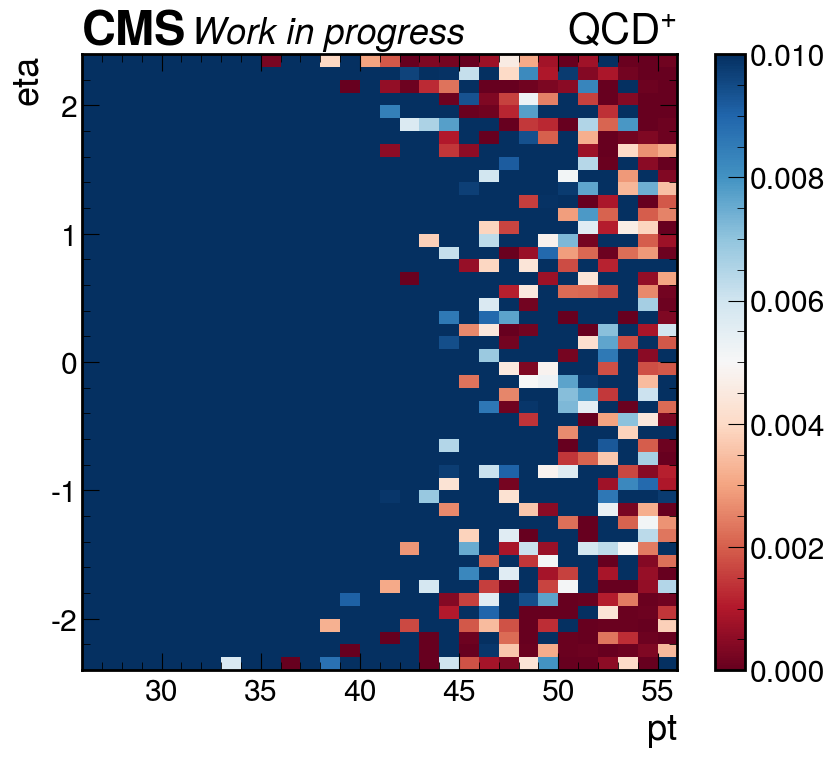

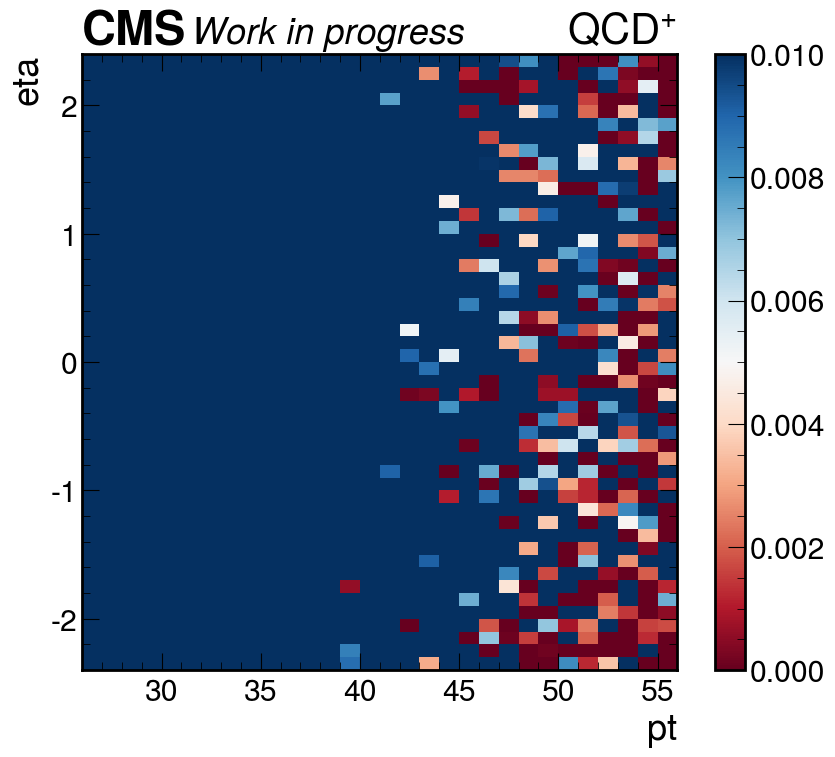

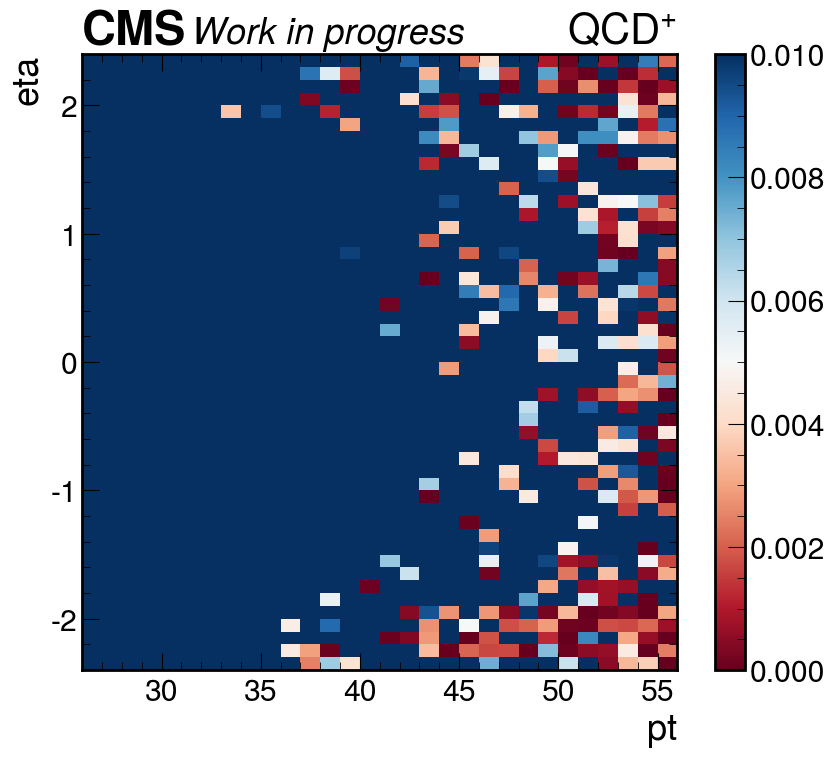

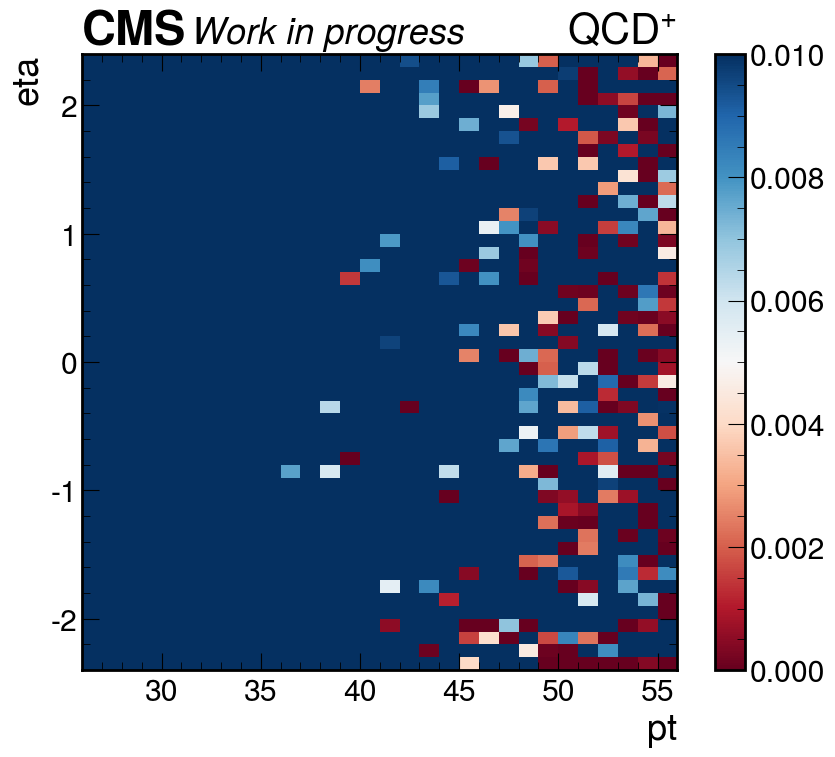

In [168]:
hQCD_D_m = hQCD[{"charge":0,"passIso":1,"passMT":1}]
hQCD_B_m = hQCD[{"charge":0,"passIso":1,"passMT":0}]
hQCD_C_m = hQCD[{"charge":0,"passIso":0,"passMT":1}]
hQCD_A_m = hQCD[{"charge":0,"passIso":0,"passMT":0}]

hQCD_D_p = hQCD[{"charge":1,"passIso":1,"passMT":1}]
hQCD_B_p = hQCD[{"charge":1,"passIso":1,"passMT":0}]
hQCD_C_p = hQCD[{"charge":1,"passIso":0,"passMT":1}]
hQCD_A_p = hQCD[{"charge":1,"passIso":0,"passMT":0}]

clim=(0, 0.01)

make_plot_2d(hQCD_A_m, "QCD_A_minus", "$QCD^{-}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_B_m, "QCD_B_minus", "$QCD^{-}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_C_m, "QCD_C_minus", "$QCD^{-}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_D_m, "QCD_D_minus", "$QCD^{-}$", ["pt","eta"],clim=clim)

make_plot_2d(hQCD_A_p, "QCD_A_plus", "$QCD^{+}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_B_p, "QCD_B_plus", "$QCD^{+}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_C_p, "QCD_C_plus", "$QCD^{+}$", ["pt","eta"],clim=clim)
make_plot_2d(hQCD_D_p, "QCD_D_plus", "$QCD^{+}$", ["pt","eta"],clim=clim)

Now at eta idx=0
Now at eta idx=1
Now at eta idx=2
Now at eta idx=0
Now at eta idx=1
Now at eta idx=2


/home/d/dwalter/WRemnants_main/wremnants/plot_tools.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.figure(figsize=(width_scale*8*width,8)), xlim


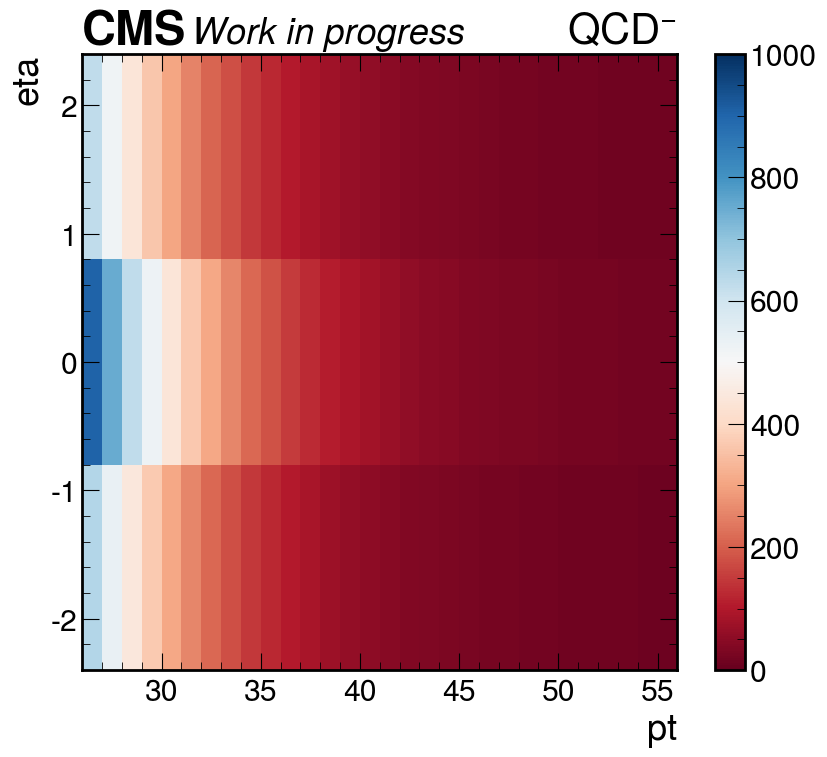

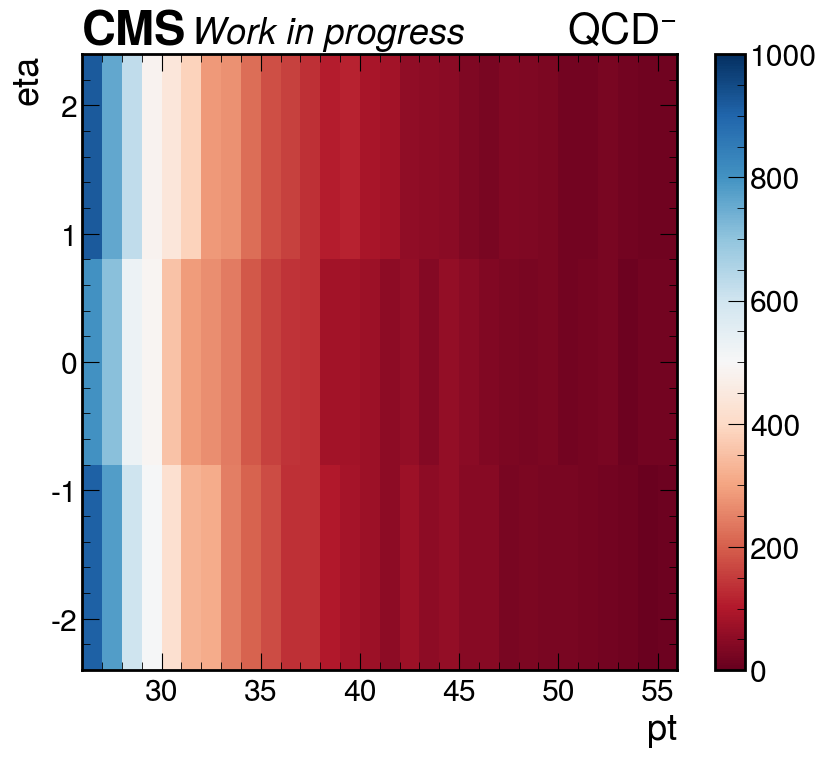

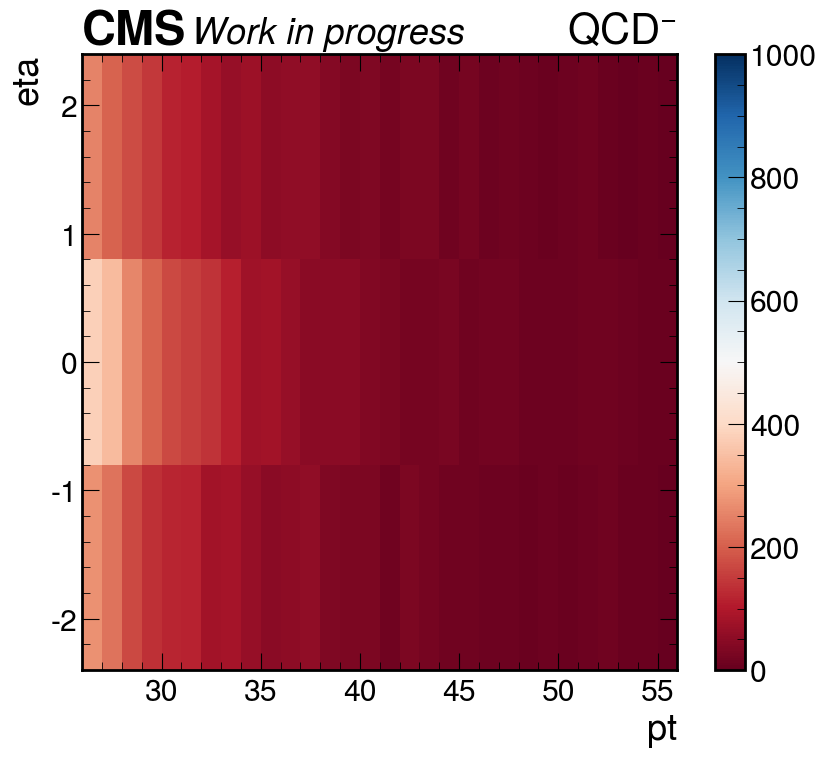

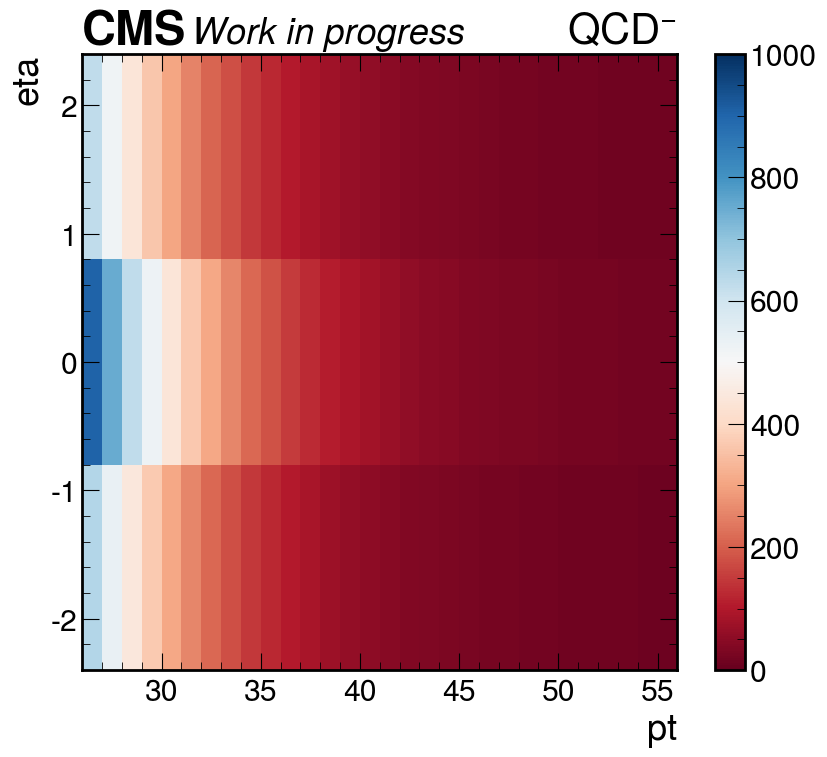

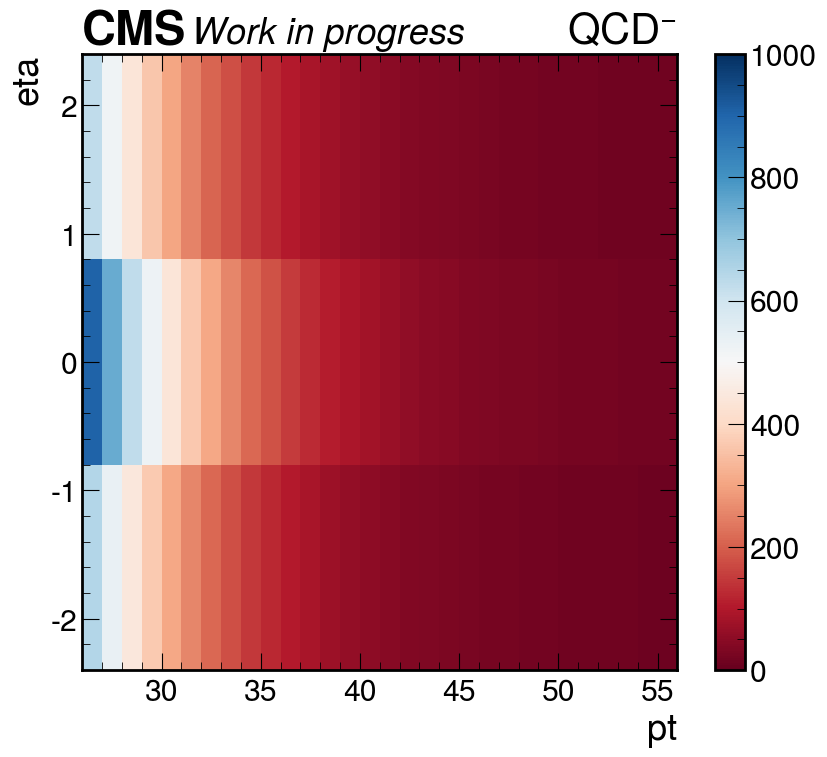

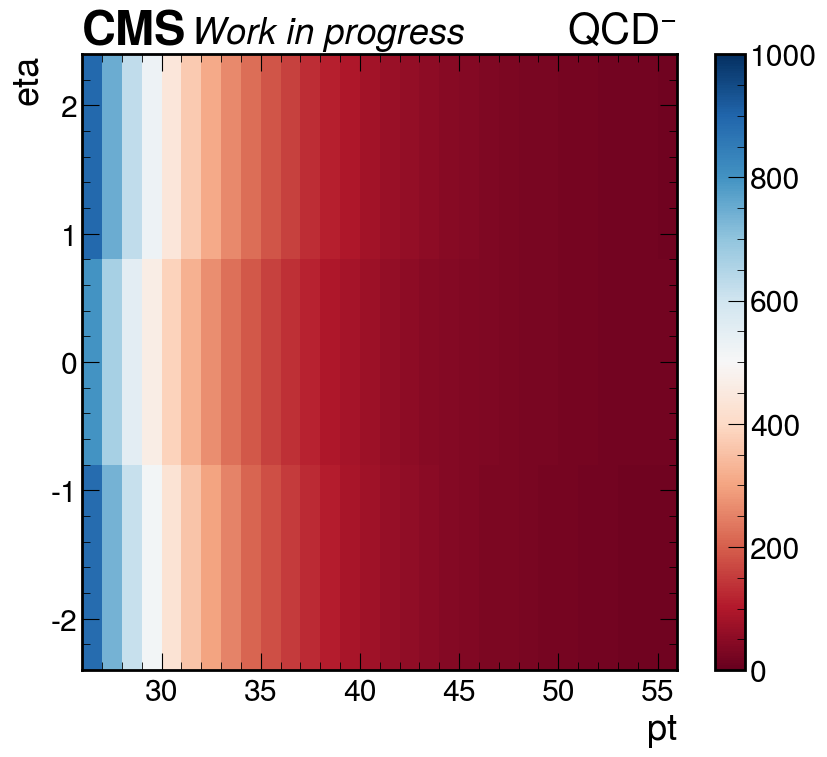

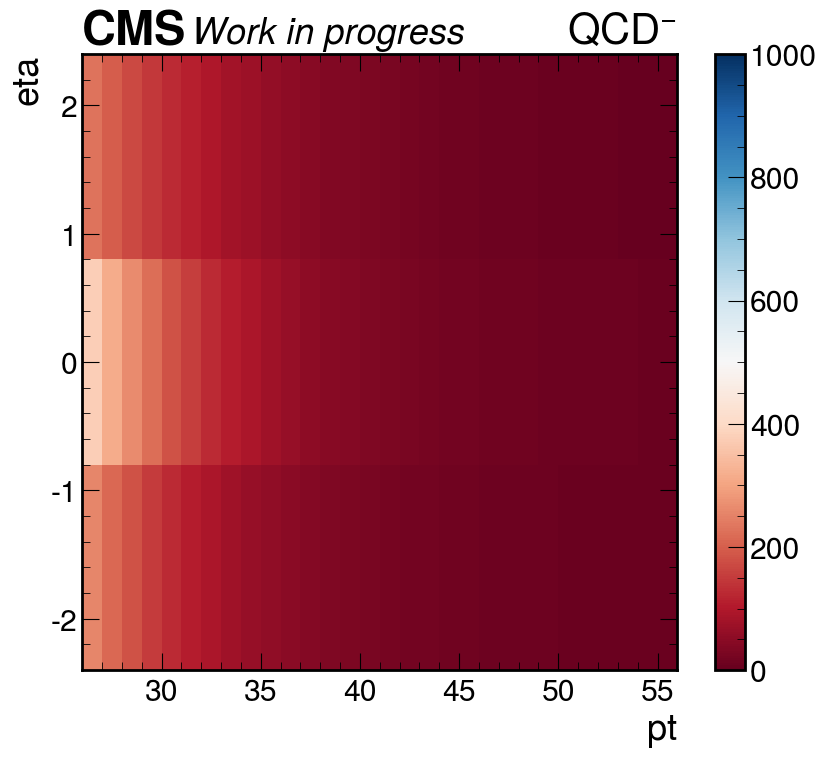

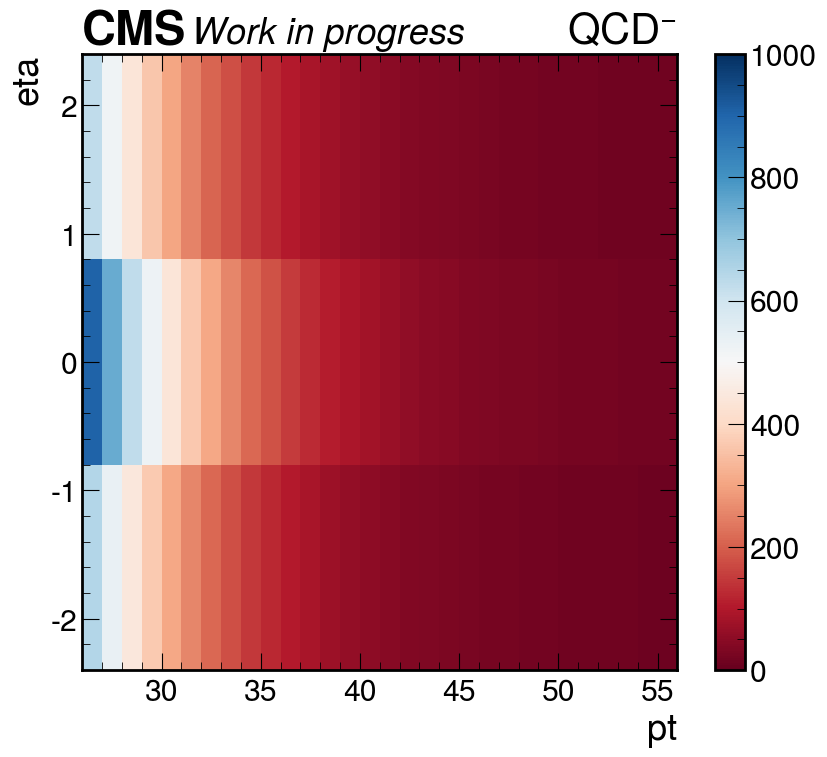

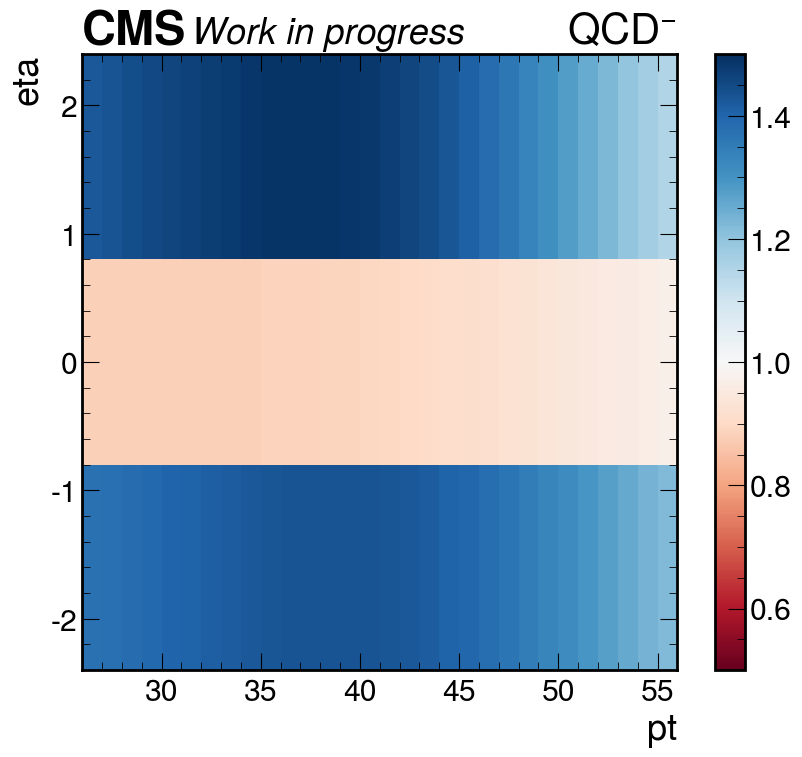

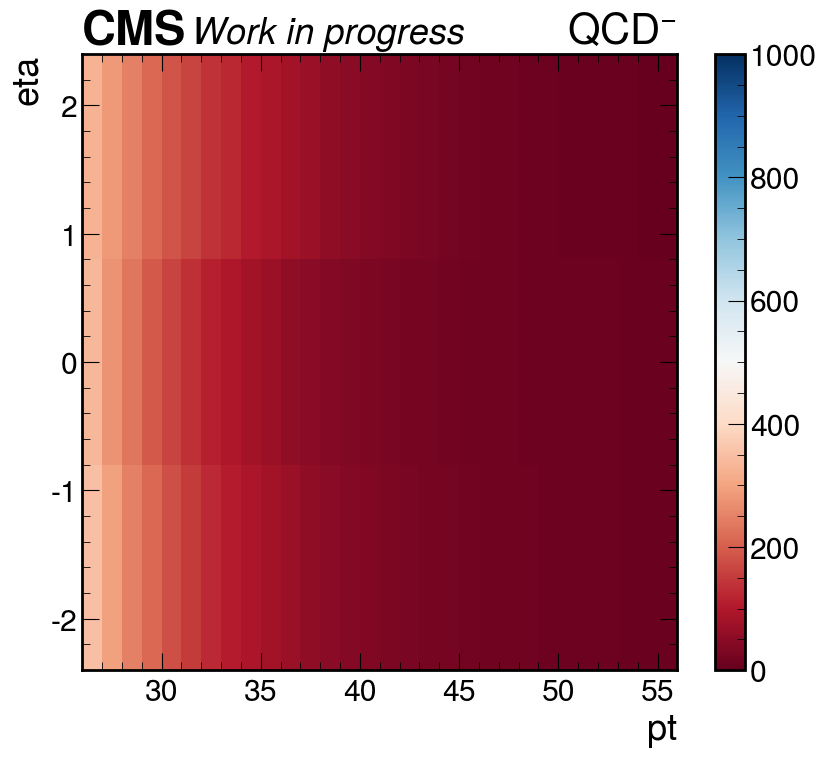

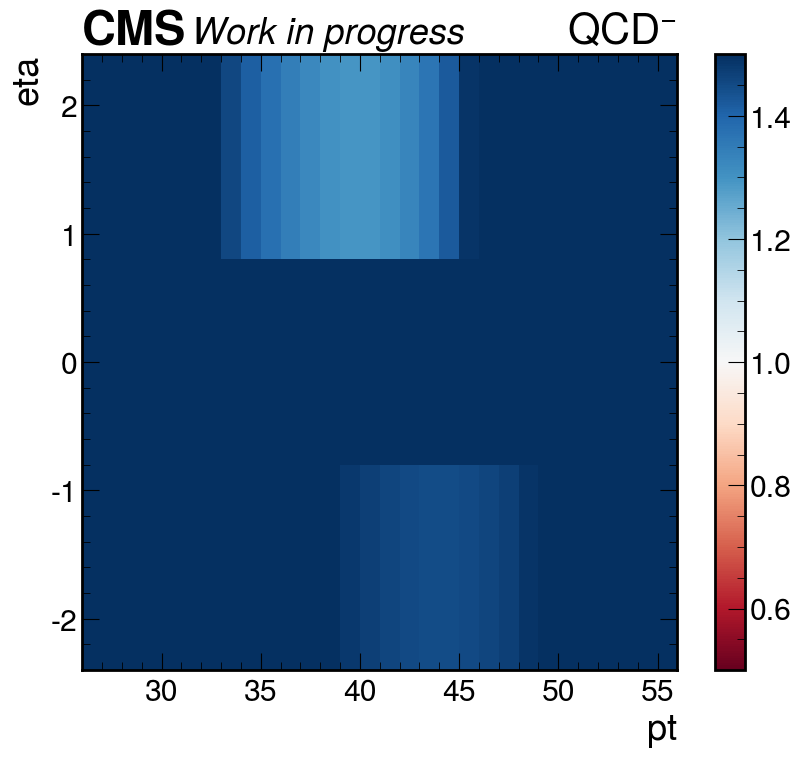

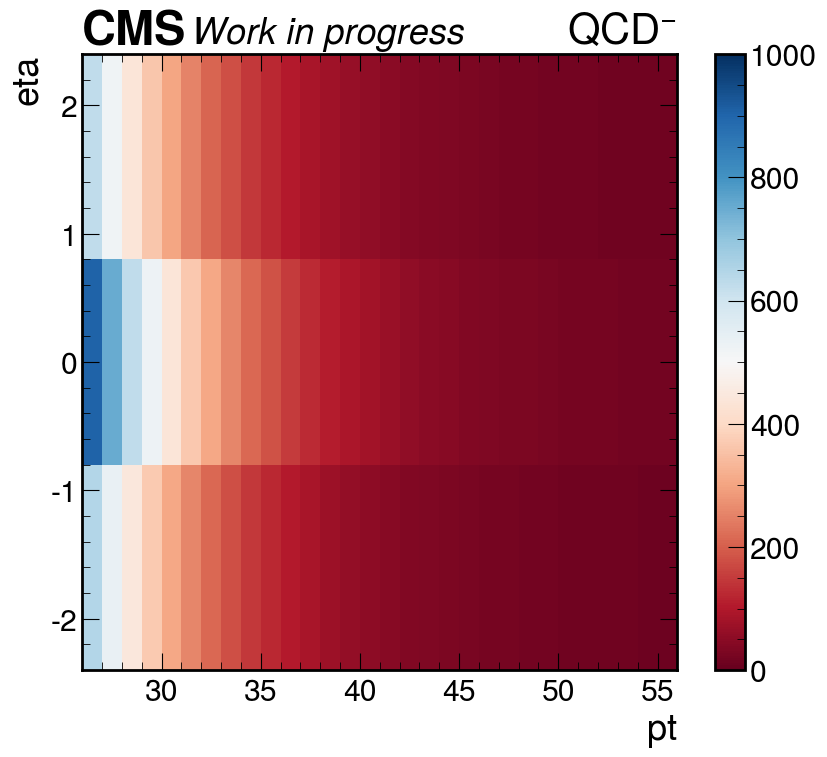

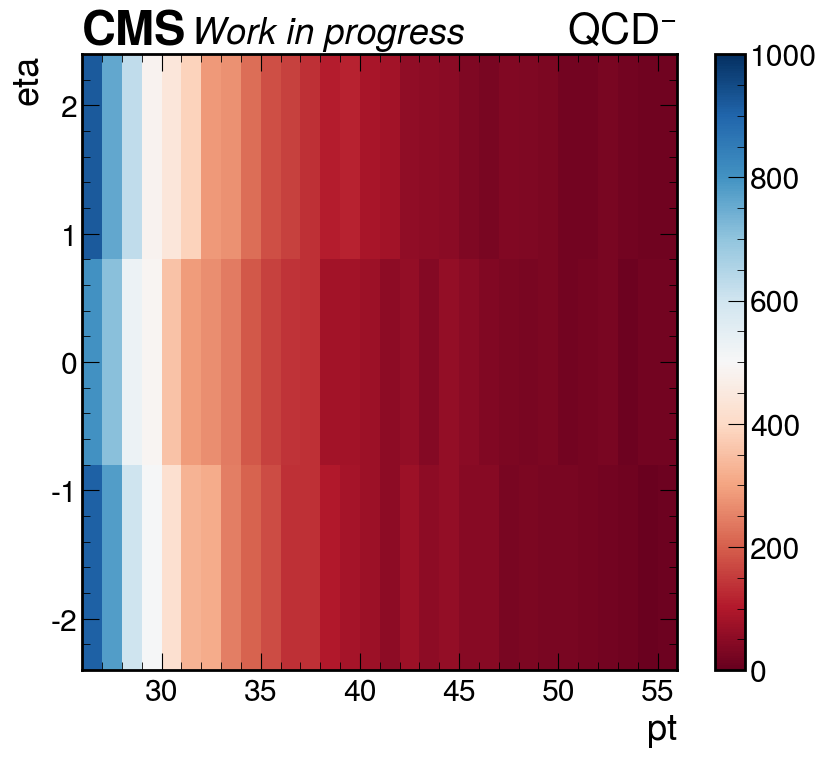

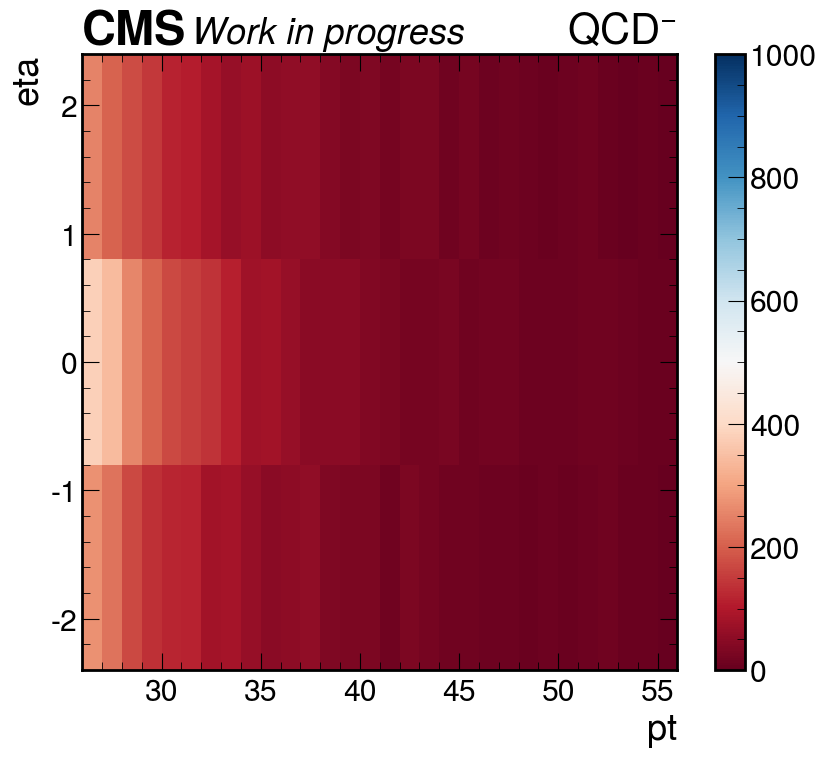

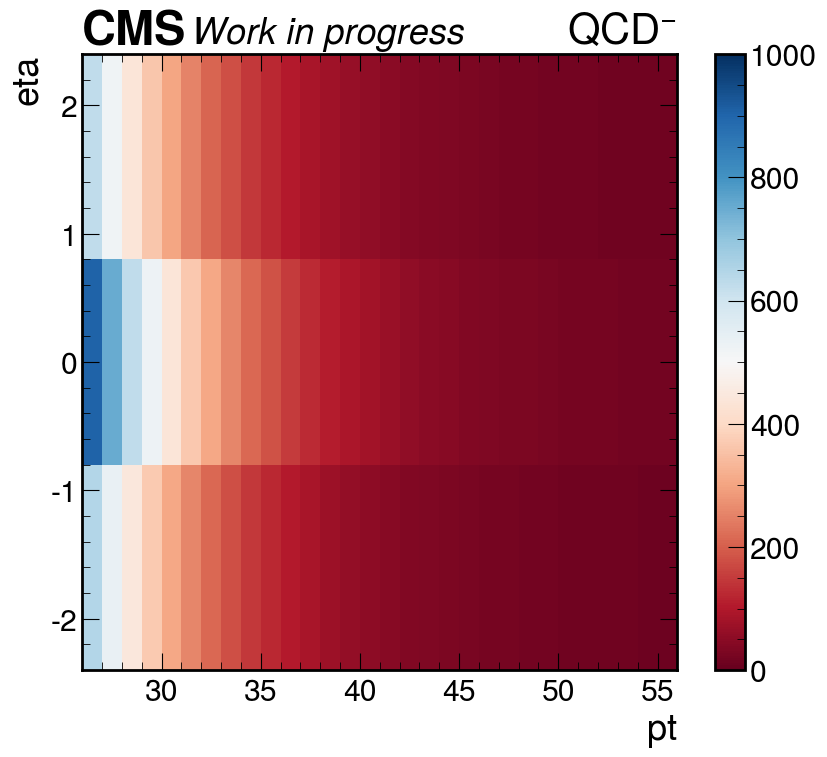

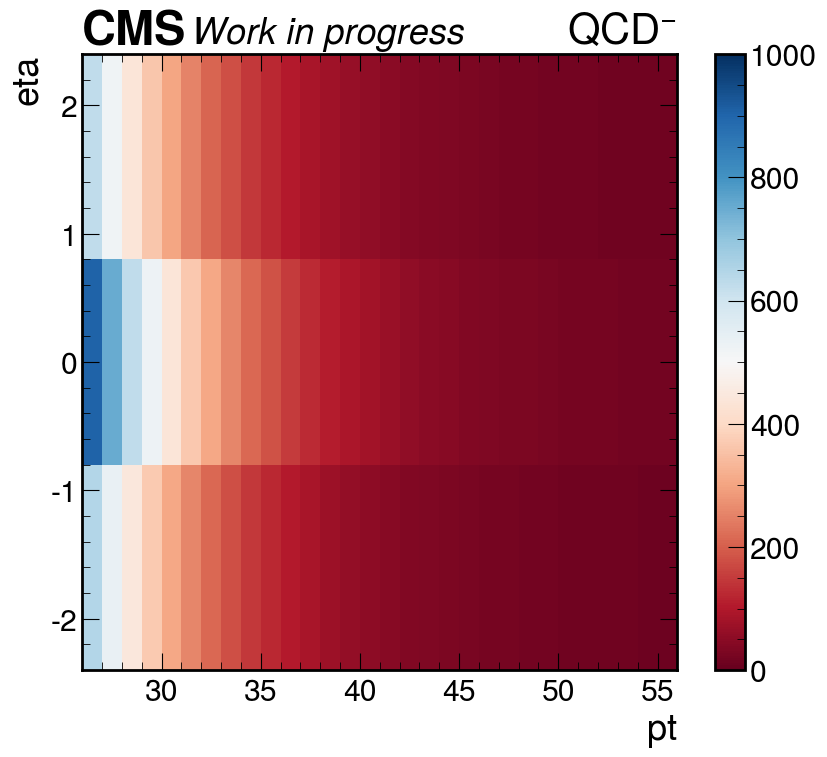

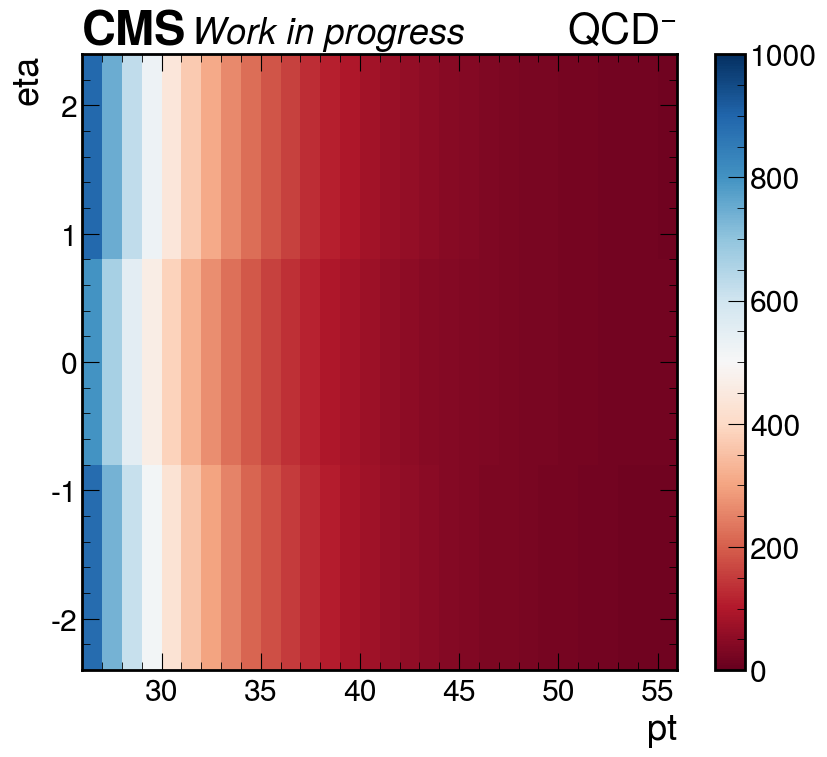

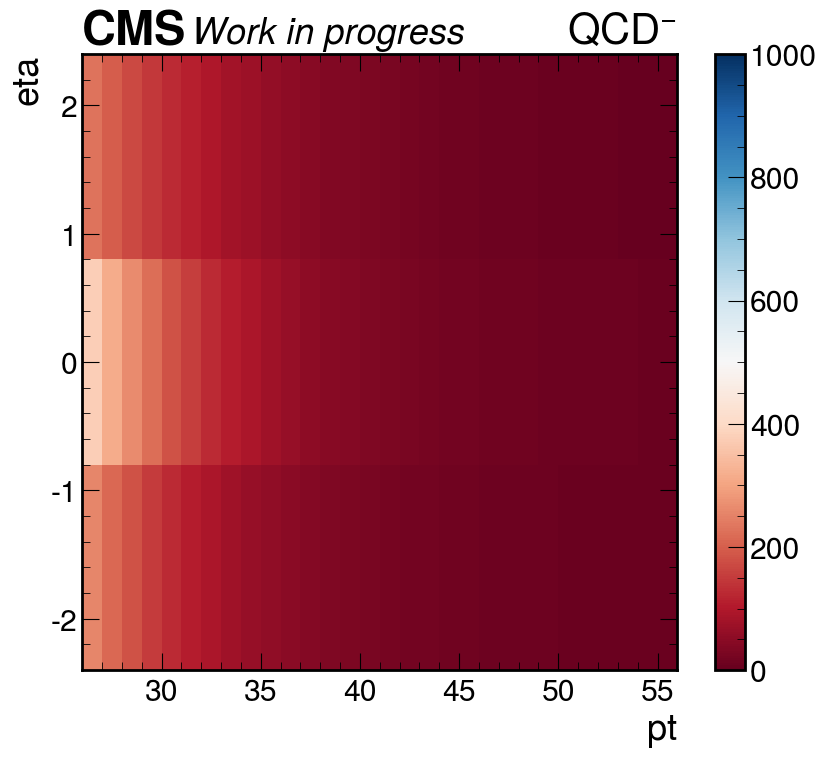

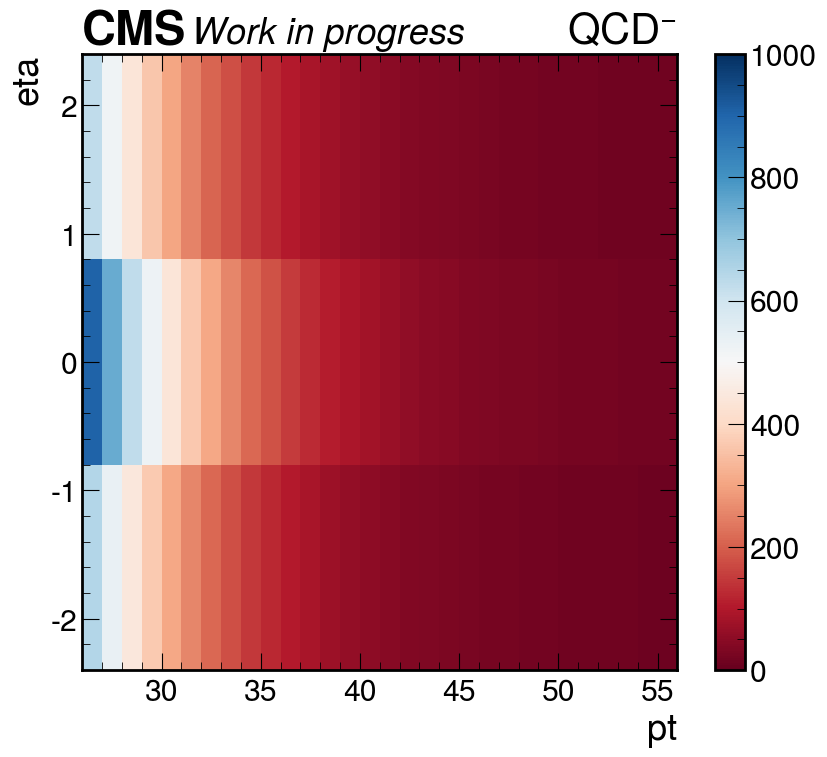

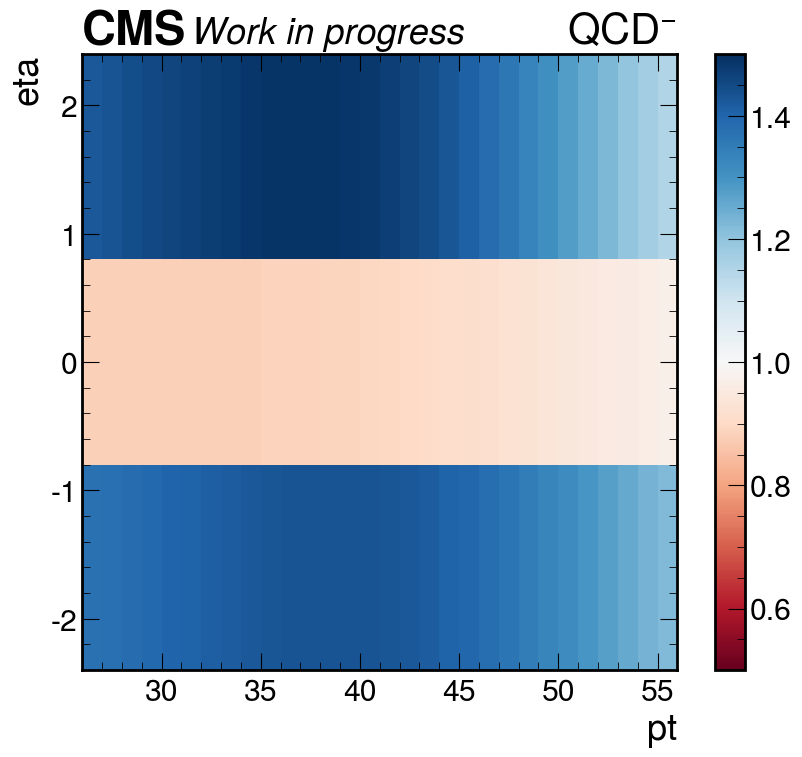

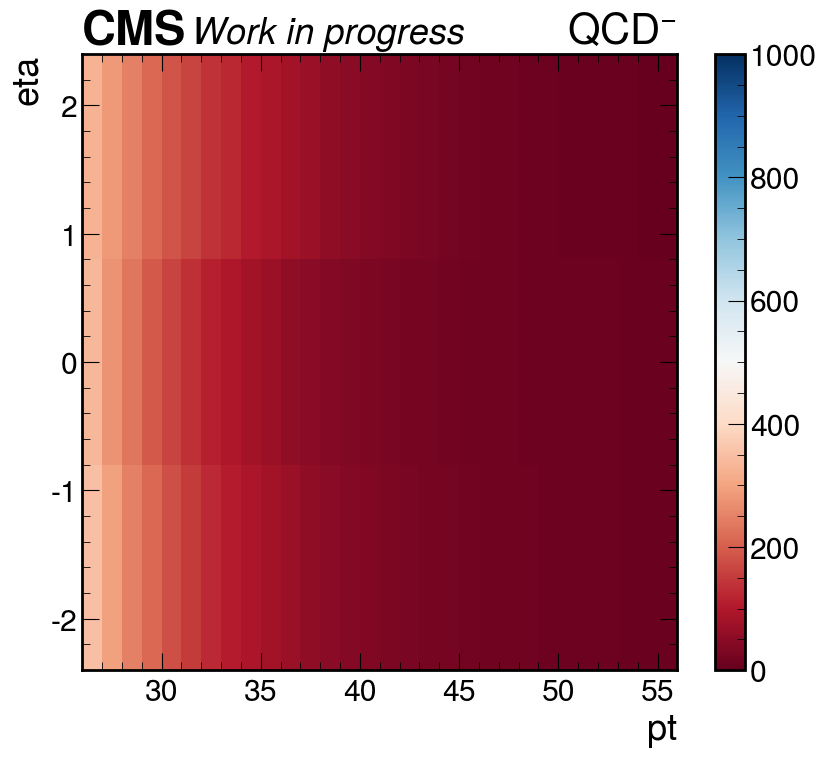

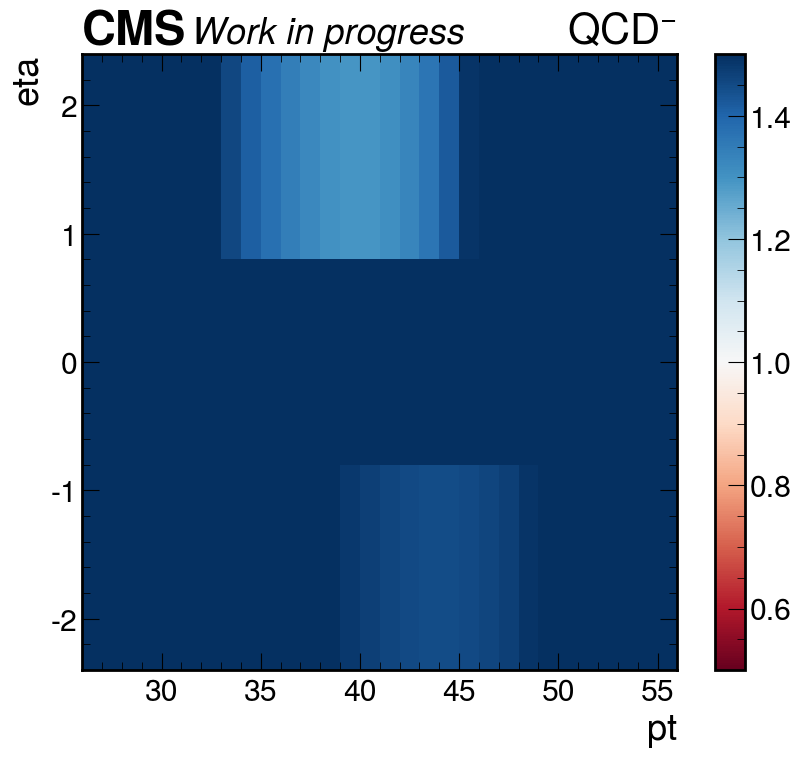

In [44]:
# plot fakes in each region separately
clim = (0, 1000)
nRebin = 16
for idx_x in (0,1):
    hQCD_D = hQCD[{"charge":idx_c,"passIso":1,"passMT":1, "eta": hist.rebin(nRebin)}]
    hQCD_B = hQCD[{"charge":idx_c,"passIso":1,"passMT":0, "eta": hist.rebin(nRebin)}]
    hQCD_C = hQCD[{"charge":idx_c,"passIso":0,"passMT":1, "eta": hist.rebin(nRebin)}]
    hQCD_D = hQCD[{"charge":idx_c,"passIso":0,"passMT":0, "eta": hist.rebin(nRebin)}]

    proc = "$QCD^{-}$" if idx_c == 0 else "$QCD^{+}$"

    
    make_plot_2d(hQCD_A, f"QCD_A_q{idx_c}", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_B, f"QCD_B_q{idx_c}", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_C, f"QCD_C_q{idx_c}", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_A, f"QCD_D_q{idx_c}", proc, ["pt","eta"],clim=clim)

        
    pos_eta = hQCD_A.axes.name.index("eta")
    for idx_eta in range(hQCD_A.axes["eta"].size):
        print(f"Now at eta idx={idx_eta}")
        
        hQCD_A_pt = hQCD_A[{"eta":idx_eta}]
        hQCD_B_pt = hQCD_B[{"eta":idx_eta}]
        hQCD_C_pt = hQCD_C[{"eta":idx_eta}]
        hQCD_D_pt = hQCD_D[{"eta":idx_eta}]

        slices = [slice(None) if n!="eta" else idx_eta for n in hQCD_A.axes.name]

        def set(h):
            h_pt = h[{"eta":idx_eta}]
            # print(f"hist = {h_pt.values()}")
            
            vals = sel.fit_multijet_bkg(h_pt)
            # print(f"vals = {vals}")
            h.view()[*slices] = np.array([(v.n,v.s**2) for v in vals])
    
        set(hQCD_A)
        set(hQCD_B)
        set(hQCD_C)
        set(hQCD_D)
    

    make_plot_2d(hQCD_A, f"QCD_A_q{idx_c}_smooth", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_B, f"QCD_B_q{idx_c}_smooth", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_C, f"QCD_C_q{idx_c}_smooth", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_D, f"QCD_D_q{idx_c}_smooth", proc, ["pt","eta"],clim=clim)

    hQCD_FR = hh.divideHists(hQCD_B, hQCD_A)
    hQCD_CBA = hh.multiplyHists(hQCD_C, hQCD_FR)
    hQCD_DCBA = hh.divideHists(hQCD_D, hQCD_CBA)
    make_plot_2d(hQCD_FR, f"FR_q{idx_c}_smooth", proc, ["pt","eta"],clim=(0.5,1.5))
    make_plot_2d(hQCD_CBA, f"CFR_q{idx_c}_smooth", proc, ["pt","eta"],clim=clim)
    make_plot_2d(hQCD_DCBA, f"DCFR_q{idx_c}_smooth", proc, ["pt","eta"],clim=(0.5,1.5))

